In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from datetime import timedelta
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
df=pd.read_csv(r"C:\Users\LENOVO\Desktop\cascading_power_failure_dataset.csv")
nodes=pd.read_csv(r"C:\Users\LENOVO\Desktop\cascading_power_failure_project\power_nodes.csv")
edges=pd.read_csv(r"C:\Users\LENOVO\Desktop\cascading_power_failure_project\power_edges.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   12000 non-null  object 
 1   node_id                12000 non-null  object 
 2   building_type          12000 non-null  object 
 3   temp_c                 11569 non-null  object 
 4   weather_severity       12000 non-null  int64  
 5   daily_load_kwh         11126 non-null  object 
 6   solar_output_kwh       11766 non-null  object 
 7   spike_event            12000 non-null  int64  
 8   vibration_g            12000 non-null  float64
 9   last_maintenance_days  12000 non-null  int64  
 10  error_code             12000 non-null  int64  
 11  battery_backup         12000 non-null  int64  
 12  max_capacity_kwh       12000 non-null  int64  
 13  outage_today           12000 non-null  int64  
 14  neighbor_outage_count  12000 non-null  int64  
 15  fa

In [4]:
df.describe

<bound method NDFrame.describe of              date  node_id  building_type temp_c  weather_severity  \
0      2024-10-06  NODE_18          Admin   27.1                 0   
1      2024-09-13  NODE_12   Lecture_Hall   31.7                 0   
2      2025-02-05  NODE_18          Admin   26.0                 0   
3      2024-09-02  NODE_16         Hostel   31.3                 2   
4      2024-08-20  NODE_10      Lab_Block   29.9                 0   
...           ...      ...            ...    ...               ...   
11995  2024-10-26  NODE_09  Sports_Center   36.4                 2   
11996  2024-08-26  NODE_17          Admin   19.2                 0   
11997  2024-10-17  NODE_09  Sports_Center   24.2                 0   
11998  2024-09-02  NODE_16         Hostel   31.3                 2   
11999  2025-02-04  NODE_12   Lecture_Hall   22.6                 0   

      daily_load_kwh solar_output_kwh  spike_event  vibration_g  \
0                466                0            0       0

In [5]:
import pandas as pd

def clean_dataset(df):
    # --- 1. Convert date column ---
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    # --- 2. Convert categorical columns ---
    cat_cols = ["building_type", "node_id"]
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")
    
    # --- 3. Convert numeric columns (safe) ---
    for col in df.columns:
        if col not in ["date", "building_type", "node_id"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # --- 4. Convert 0/1 integer columns to bool ---
    # exclude fail_within_7_days (keep as float)
    exclude = ["fail_within_7_days"]
    for col in df.columns:
        if col not in exclude and df[col].dropna().isin([0, 1]).all():
            df[col] = df[col].astype(bool)

    return df


# Example usage
df = clean_dataset(df)
print(df.dtypes)
df.shape

date                     datetime64[ns]
node_id                        category
building_type                  category
temp_c                          float64
weather_severity                  int64
daily_load_kwh                  float64
solar_output_kwh                float64
spike_event                        bool
vibration_g                     float64
last_maintenance_days             int64
error_code                        int64
battery_backup                     bool
max_capacity_kwh                  int64
outage_today                       bool
neighbor_outage_count             int64
failure_prob_7d                 float64
fail_within_7_days                int64
dtype: object


(12000, 17)

In [6]:
df.head(5)

,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,error_code,battery_backup,max_capacity_kwh,outage_today,neighbor_outage_count,failure_prob_7d,fail_within_7_days
0,2024-10-06,NODE_18,Admin,27.1,0,466.0,0.0,False,0.0170,219,0,True,2000,False,0,0.000000,0
1,2024-09-13,NODE_12,Lecture_Hall,31.7,0,425.0,638.0,False,0.0044,300,0,False,2000,True,0,NaN,1
2,2025-02-05,NODE_18,Admin,26.0,0,NaN,0.0,True,0.0525,18,0,True,2000,True,2,NaN,1
3,2024-09-02,NODE_16,Hostel,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1
4,2024-08-20,NODE_10,Lab_Block,29.9,0,1990.0,0.0,False,0.0079,405,3,False,6000,False,0,0.258319,1


In [7]:
def clean_time_series(df):
    """Clean real-world power grid time series data."""
    df = df.copy()
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Convert date column
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    # Convert numeric columns (except node_id)
    for col in df.columns:
        if col not in ["node_id", "date"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df


In [8]:
def clean_nodes(nodes):
    """Clean nodes metadata for power grid."""
    nodes = nodes.copy()
    nodes.dropna(inplace=True)
    nodes.reset_index(drop=True, inplace=True)
    
    if "node_id" in nodes.columns:
        nodes["node_id"] = nodes["node_id"].astype(str)
    
    # Convert numeric columns (except node_id and building_type)
    for col in nodes.columns:
        if col not in ["node_id", "building_type"]:
            nodes[col] = pd.to_numeric(nodes[col], errors="coerce")
    
    return nodes


In [9]:
def clean_edges(edges):
    """Clean edges metadata for power grid (columns 'from' and 'to')."""
    edges = edges.copy()
    edges.dropna(inplace=True)
    edges.reset_index(drop=True, inplace=True)
    
    return edges


In [10]:
print("Cleaned datasets...")

df_clean = clean_time_series(df)
nodes_clean = clean_nodes(nodes)
edges_clean = clean_edges(edges)

print(f"df_clean: {df_clean.shape}")
print(f"nodes_clean: {nodes_clean.shape}")
print(f"edges_clean: {edges_clean.shape}")


Cleaned datasets...
df_clean: (9453, 17)
nodes_clean: (20, 5)
edges_clean: (31, 2)


In [11]:
df_clean.head()

,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,error_code,battery_backup,max_capacity_kwh,outage_today,neighbor_outage_count,failure_prob_7d,fail_within_7_days
0,2024-10-06,NODE_18,NaN,27.1,0,466.0,0.0,False,0.0170,219,0,True,2000,False,0,0.000000,0
1,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1
2,2024-08-20,NODE_10,NaN,29.9,0,1990.0,0.0,False,0.0079,405,3,False,6000,False,0,0.258319,1
3,2024-08-20,NODE_10,NaN,29.9,0,1990.0,0.0,False,0.0079,405,3,False,6000,False,0,0.258319,1
4,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1


In [12]:
df_clean.tail()

,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,error_code,battery_backup,max_capacity_kwh,outage_today,neighbor_outage_count,failure_prob_7d,fail_within_7_days
9448,2024-10-26,NODE_09,NaN,36.4,2,1053.0,0.0,False,0.0180,8,0,False,4000,True,0,0.268414,1
9449,2024-08-26,NODE_17,NaN,19.2,0,625.0,473.0,True,0.0197,216,0,False,5000,False,0,0.029609,0
9450,2024-10-17,NODE_09,NaN,24.2,0,1573.0,0.0,False,0.0148,193,0,False,4000,True,0,0.027005,1
9451,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1
9452,2025-02-04,NODE_12,NaN,22.6,0,570.0,610.0,False,0.0308,45,0,False,2000,False,0,0.029896,0


In [13]:
df_clean.shape

(9453, 17)

In [14]:
print("=== NODES DATA ===")
print(nodes_clean.head())
print(f"\nNodes shape: {nodes_clean.shape}")
print(f"Building types: {nodes_clean['building_type'].value_counts().to_dict()}")


=== NODES DATA ===
   node_id  building_type  max_capacity_kwh  installed_solar_kw  \
0  NODE_01        Library              6000                   0   
1  NODE_02         Hostel              2000                 100   
2  NODE_03        Library              3000                   0   
3  NODE_04  Sports_Center              6000                   0   
4  NODE_05          Admin              6000                  50   

   has_battery_backup  
0                   0  
1                   0  
2                   1  
3                   0  
4                   0  

Nodes shape: (20, 5)
Building types: {'Sports_Center': 5, 'Admin': 5, 'Hostel': 4, 'Library': 2, 'Lab_Block': 2, 'Lecture_Hall': 2}


In [15]:
print("\n=== EDGES DATA ===")
print(edges_clean.head())
print(f"\nEdges shape: {edges_clean.shape}")



=== EDGES DATA ===
      from       to
0  NODE_01  NODE_03
1  NODE_01  NODE_09
2  NODE_01  NODE_11
3  NODE_01  NODE_14
4  NODE_01  NODE_18

Edges shape: (31, 2)


In [16]:
print("\n=== TIME SERIES DATA ===")
print(df_clean.head())
print(f"\nTime series shape: {df_clean.shape}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")



=== TIME SERIES DATA ===
        date  node_id  building_type  temp_c  weather_severity  \
0 2024-10-06  NODE_18            NaN    27.1                 0   
1 2024-09-02  NODE_16            NaN    31.3                 2   
2 2024-08-20  NODE_10            NaN    29.9                 0   
3 2024-08-20  NODE_10            NaN    29.9                 0   
4 2024-09-02  NODE_16            NaN    31.3                 2   

   daily_load_kwh  solar_output_kwh  spike_event  vibration_g  \
0           466.0               0.0        False       0.0170   
1          1179.0               0.0        False       0.0205   
2          1990.0               0.0        False       0.0079   
3          1990.0               0.0        False       0.0079   
4          1179.0               0.0        False       0.0205   

   last_maintenance_days  error_code  battery_backup  max_capacity_kwh  \
0                    219           0            True              2000   
1                    429           1  

In [17]:
failure_stats = df_clean.groupby('node_id')['fail_within_7_days'].agg(['count', 'sum', 'mean'])
failure_stats.columns = ['total_days', 'failure_days', 'failure_rate']
failure_stats = failure_stats.sort_values('failure_rate', ascending=False)

print(f"\n=== FAILURE STATISTICS ===")
print(f"Overall failure rate: {df_clean['fail_within_7_days'].mean():.4f}")
print(f"Top 5 most failure-prone nodes:")
print(failure_stats.head())



=== FAILURE STATISTICS ===
Overall failure rate: 0.4567
Top 5 most failure-prone nodes:
         total_days  failure_days  failure_rate
node_id                                        
NODE_09        1644          1399      0.850973
NODE_16        1426          1157      0.811360
NODE_12        1016           762      0.750000
NODE_10         660           395      0.598485
NODE_18         488           219      0.448770


In [18]:
print(df_clean['building_type'].value_counts(dropna=False))
print(df_clean['fail_within_7_days'].value_counts(dropna=False))

building_type
NaN    9453
Name: count, dtype: int64
fail_within_7_days
0    5136
1    4317
Name: count, dtype: int64


In [19]:
print(nodes.columns)

Index(['node_id', 'building_type', 'max_capacity_kwh', 'installed_solar_kw',
       'has_battery_backup'],
      dtype='object')


In [20]:
# Check column names
print(df_clean.columns)


Index(['date', 'node_id', 'building_type', 'temp_c', 'weather_severity',
       'daily_load_kwh', 'solar_output_kwh', 'spike_event', 'vibration_g',
       'last_maintenance_days', 'error_code', 'battery_backup',
       'max_capacity_kwh', 'outage_today', 'neighbor_outage_count',
       'failure_prob_7d', 'fail_within_7_days'],
      dtype='object')


In [21]:
# Drop building_type from df_clean before merge
timeseries_df = df_clean.drop(columns=['building_type'], errors='ignore').merge(
    nodes_clean[['node_id', 'building_type']],
    on='node_id',
    how='left'
)
df_clean.shape

(9453, 17)

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
building_type,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp_c,9453.0,27.581932,4.650565,14.600,19.1000,20.6000,24.100000,26.500000,31.300000,36.400000,36.400000,40.800000
weather_severity,9453.0,0.588385,0.916845,0.000,0.0000,0.0000,0.000000,0.000000,1.000000,2.000000,3.000000,3.000000
daily_load_kwh,9453.0,982.485983,425.589720,0.000,92.0000,379.0000,672.000000,988.000000,1186.000000,1702.400000,1990.000000,2517.000000
solar_output_kwh,9453.0,147.173490,224.125807,0.000,0.0000,0.0000,0.000000,0.000000,269.000000,638.000000,658.000000,792.000000
vibration_g,9453.0,0.017341,0.011634,-0.019,-0.0043,-0.0043,0.010200,0.018000,0.023000,0.036500,0.052500,0.053000
last_maintenance_days,9453.0,172.346134,162.530776,0.000,1.0000,7.0000,20.000000,114.000000,300.000000,451.000000,451.000000,494.000000
error_code,9453.0,0.260764,0.704425,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000
max_capacity_kwh,9453.0,4286.469904,1621.514769,2000.000,2000.0000,2000.0000,3000.000000,4000.000000,6000.000000,6000.000000,6000.000000,6000.000000
neighbor_outage_count,9453.0,0.082831,0.350645,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000


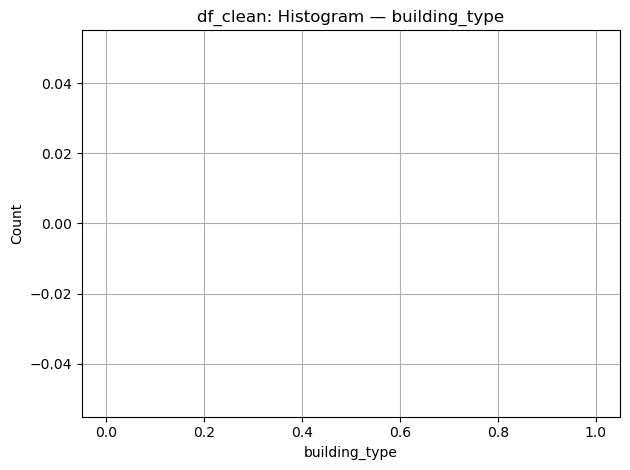

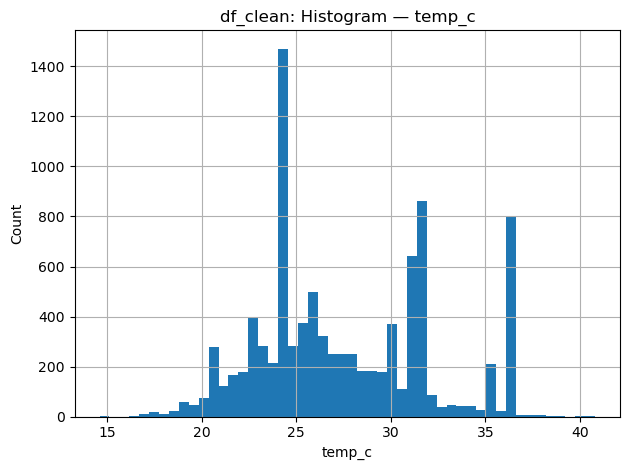

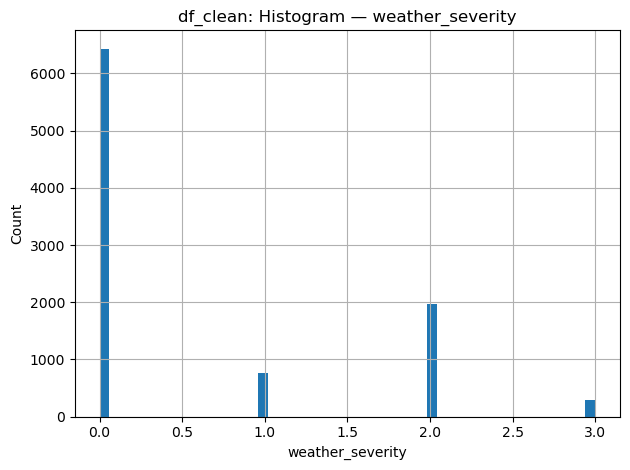

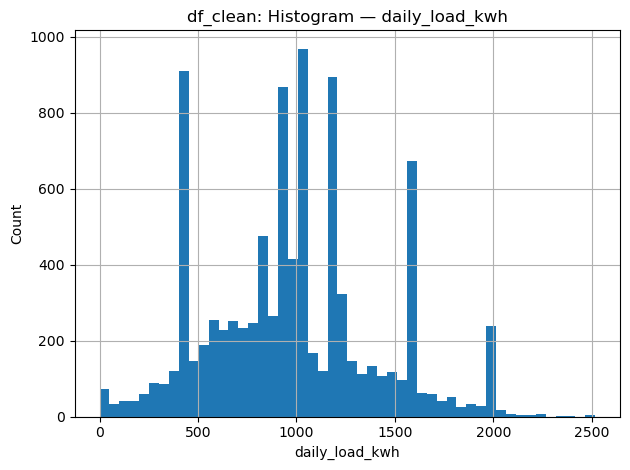

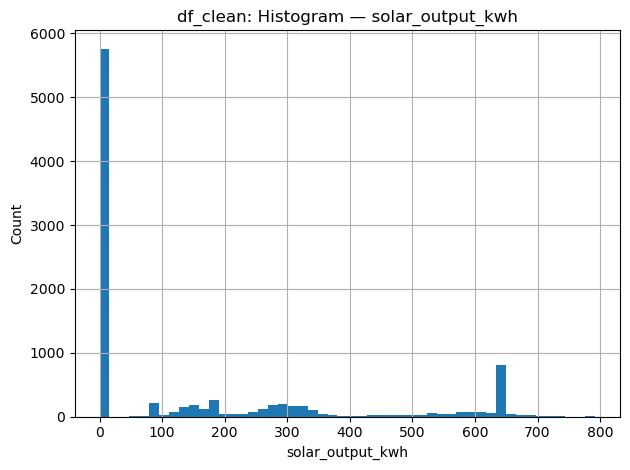

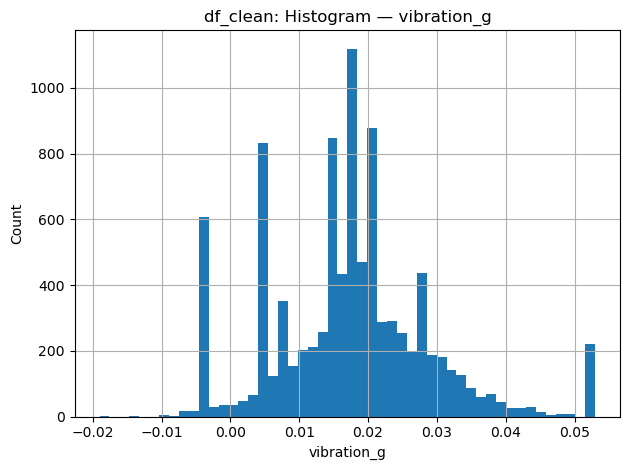

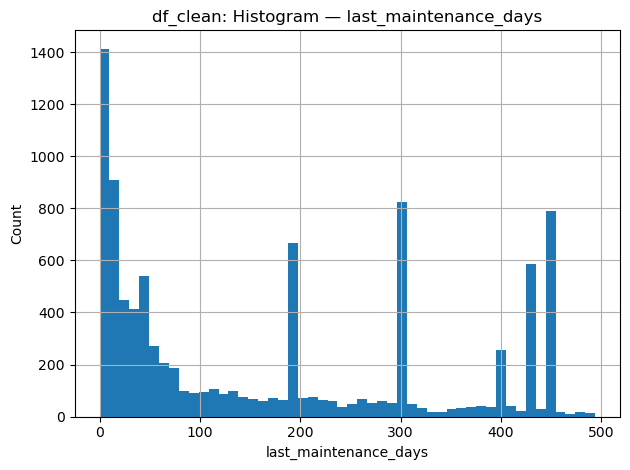

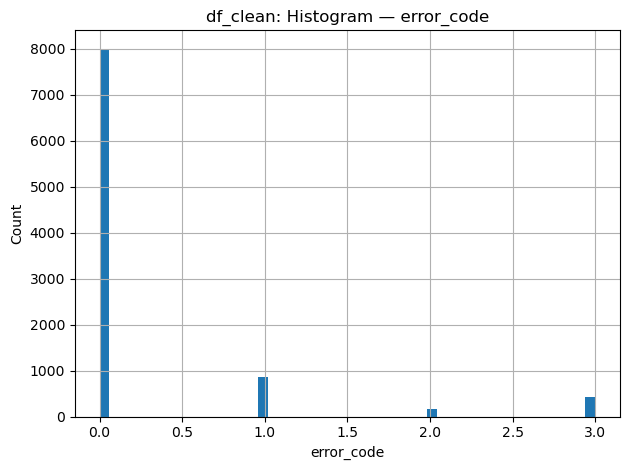

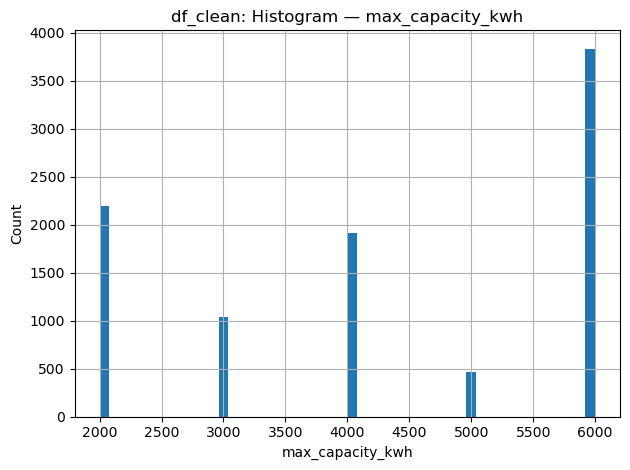

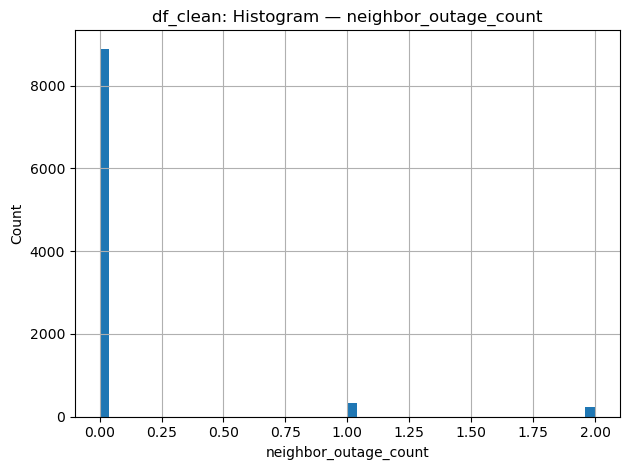

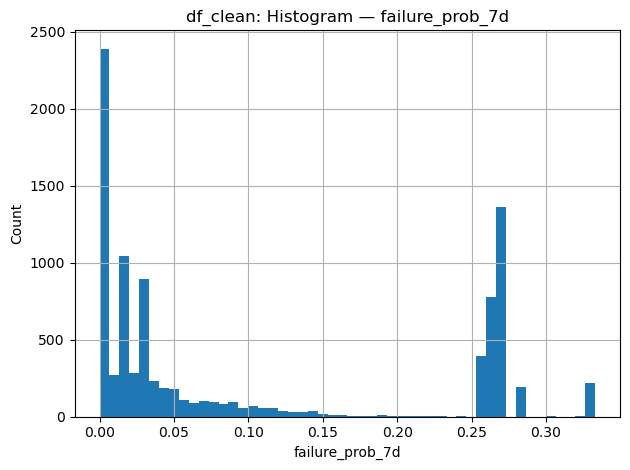

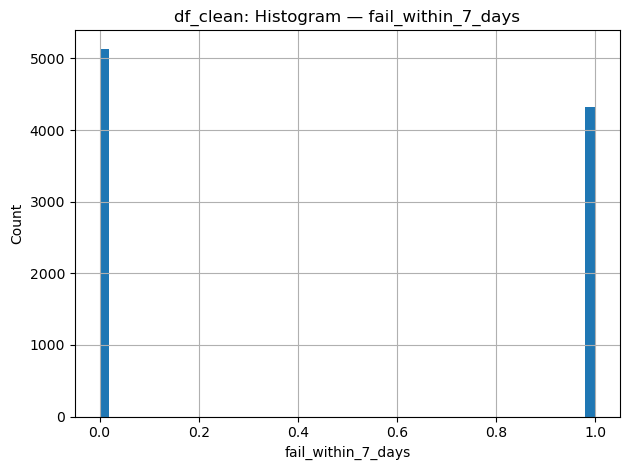

[SKIP] No numeric columns in edges_clean


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
max_capacity_kwh,20.0,4300.00,1657.518754,2000.0,2000.0,2000.0,3000.0,4500.0,6000.00,6000.0,6000.0,6000.0
installed_solar_kw,20.0,60.00,73.627798,0.0,0.0,0.0,0.0,25.0,100.00,200.0,200.0,200.0
has_battery_backup,20.0,0.25,0.444262,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1.0,1.0


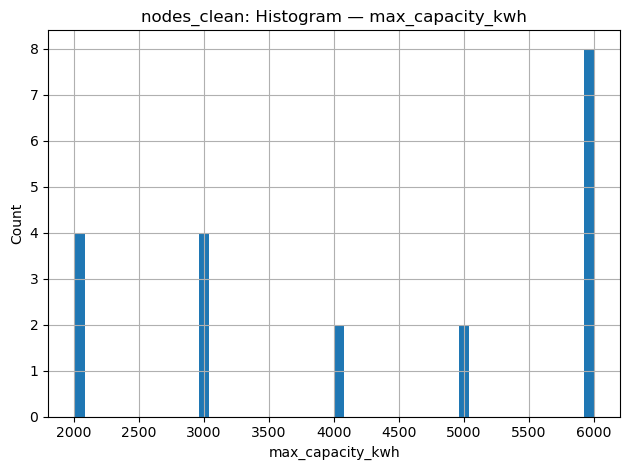

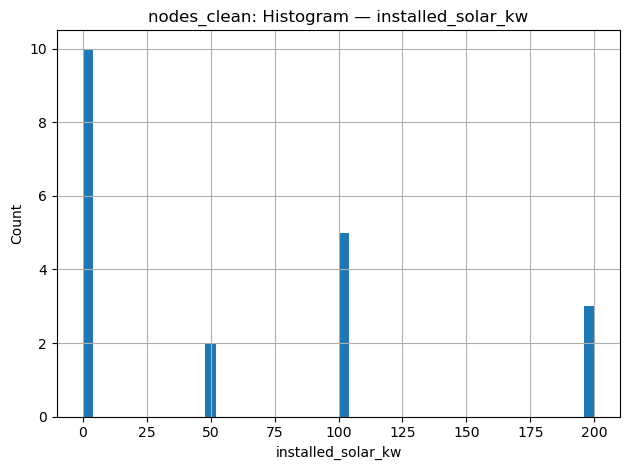

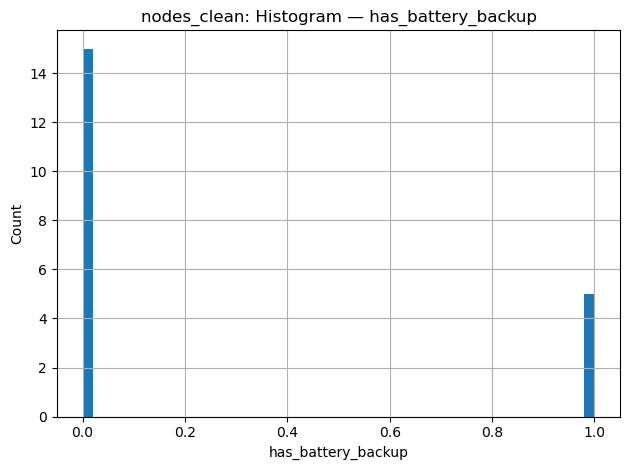

In [22]:
def numeric_summary(df, name):
    if df is None: 
        print(f"[SKIP] {name} missing")
        return
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    if not num_cols:
        print(f"[SKIP] No numeric columns in {name}")
        return
    display(df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T)

    # Histograms
    for col in num_cols[:20]:  
        plt.figure()
        df[col].dropna().hist(bins=50)
        plt.title(f"{name}: Histogram — {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

numeric_summary(df_clean, "df_clean")
numeric_summary(edges_clean,  "edges_clean")
numeric_summary(nodes_clean,  "nodes_clean")

In [23]:
def outlier_report(df, name, z_thresh=4.0):
    if df is None: 
        print(f"[SKIP] {name} missing")
        return
    
    num_cols = df.select_dtypes(include=np.number).columns
    if not len(num_cols): 
        print(f"[SKIP] {name} has no numeric columns")
        return
    
    print(f"\n=== Outlier Report for {name} ===")
    
    # --- Z-Score based outliers
    outlier_counts = {}
    for col in num_cols:
        s = df[col].dropna()
        if s.empty: 
            outlier_counts[col] = 0
            continue
        z = stats.zscore(s)
        outlier_counts[col] = int((np.abs(z) > z_thresh).sum())

    report = pd.DataFrame({
        f"outliers_|z|>{z_thresh}": pd.Series(outlier_counts)
    }).sort_values(by=f"outliers_|z|>{z_thresh}", ascending=False)
    
    print("\n[Z-score method]")
    print(report)
    
    # --- IQR based stats
    iqr_stats = {}
    for col in num_cols:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr): 
            continue
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        iqr_stats[col] = {"q1":q1, "q3":q3, "lower":lower, "upper":upper}
    
    if iqr_stats:
        print("\n[IQR method]")
        print(pd.DataFrame(iqr_stats).T)
    else:
        print("\n[IQR method] No valid numeric columns")

In [24]:
outlier_report(df_clean, "df_clean")
outlier_report(edges, "edges_clean")
outlier_report(nodes, "nodes_clean")


=== Outlier Report for df_clean ===

[Z-score method]
                       outliers_|z|>4.0
neighbor_outage_count               222
building_type                         0
temp_c                                0
weather_severity                      0
daily_load_kwh                        0
solar_output_kwh                      0
vibration_g                           0
last_maintenance_days                 0
error_code                            0
max_capacity_kwh                      0
failure_prob_7d                       0
fail_within_7_days                    0

[IQR method]
                                q1           q3        lower         upper
temp_c                   24.100000    31.300000    13.300000     42.100000
weather_severity          0.000000     1.000000    -1.500000      2.500000
daily_load_kwh          672.000000  1186.000000   -99.000000   1957.000000
solar_output_kwh          0.000000   269.000000  -403.500000    672.500000
vibration_g               0.010200  

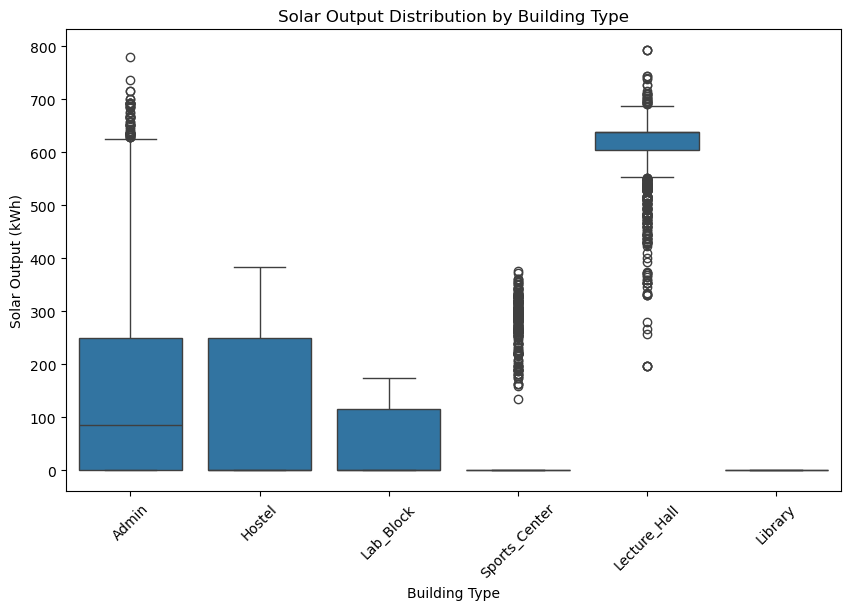

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(data=timeseries_df, x="building_type", y="solar_output_kwh")
plt.title("Solar Output Distribution by Building Type")
plt.xticks(rotation=45)
plt.ylabel("Solar Output (kWh)")
plt.xlabel("Building Type")
plt.show()

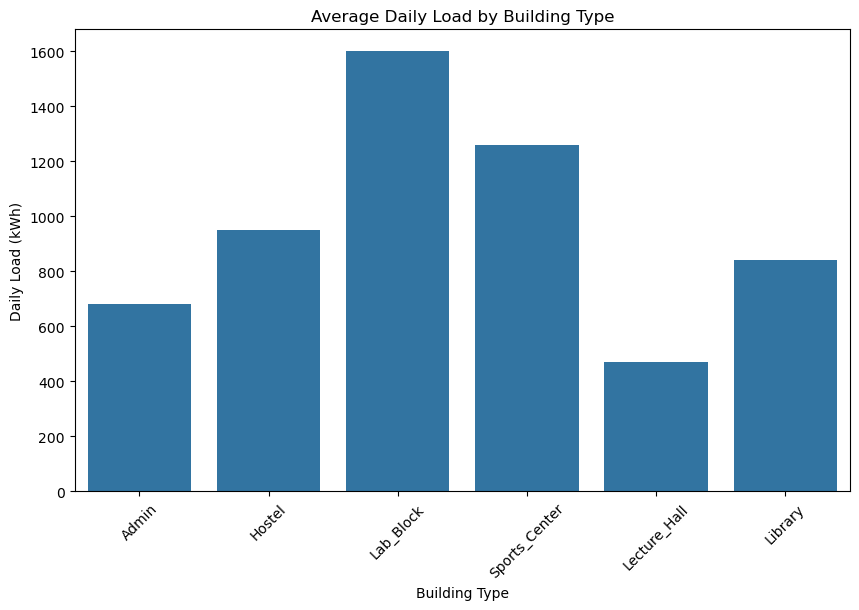

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(data=timeseries_df, x="building_type", y="daily_load_kwh", estimator="mean", errorbar=None)
plt.title("Average Daily Load by Building Type")
plt.xticks(rotation=45)
plt.ylabel("Daily Load (kWh)")
plt.xlabel("Building Type")
plt.show()

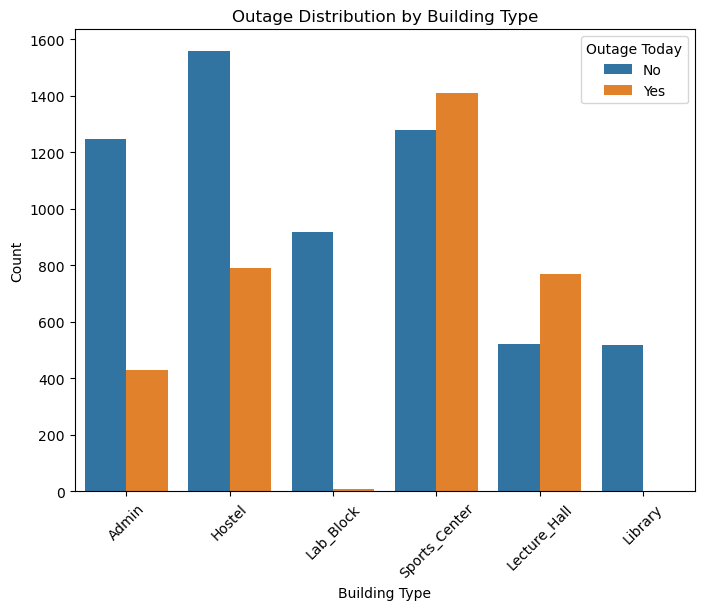

In [27]:
# 3. Outage count comparison by building type
plt.figure(figsize=(8,6))
sns.countplot(data=timeseries_df, x="building_type", hue="outage_today")
plt.title("Outage Distribution by Building Type")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Building Type")
plt.legend(title="Outage Today", labels=["No", "Yes"])
plt.show()

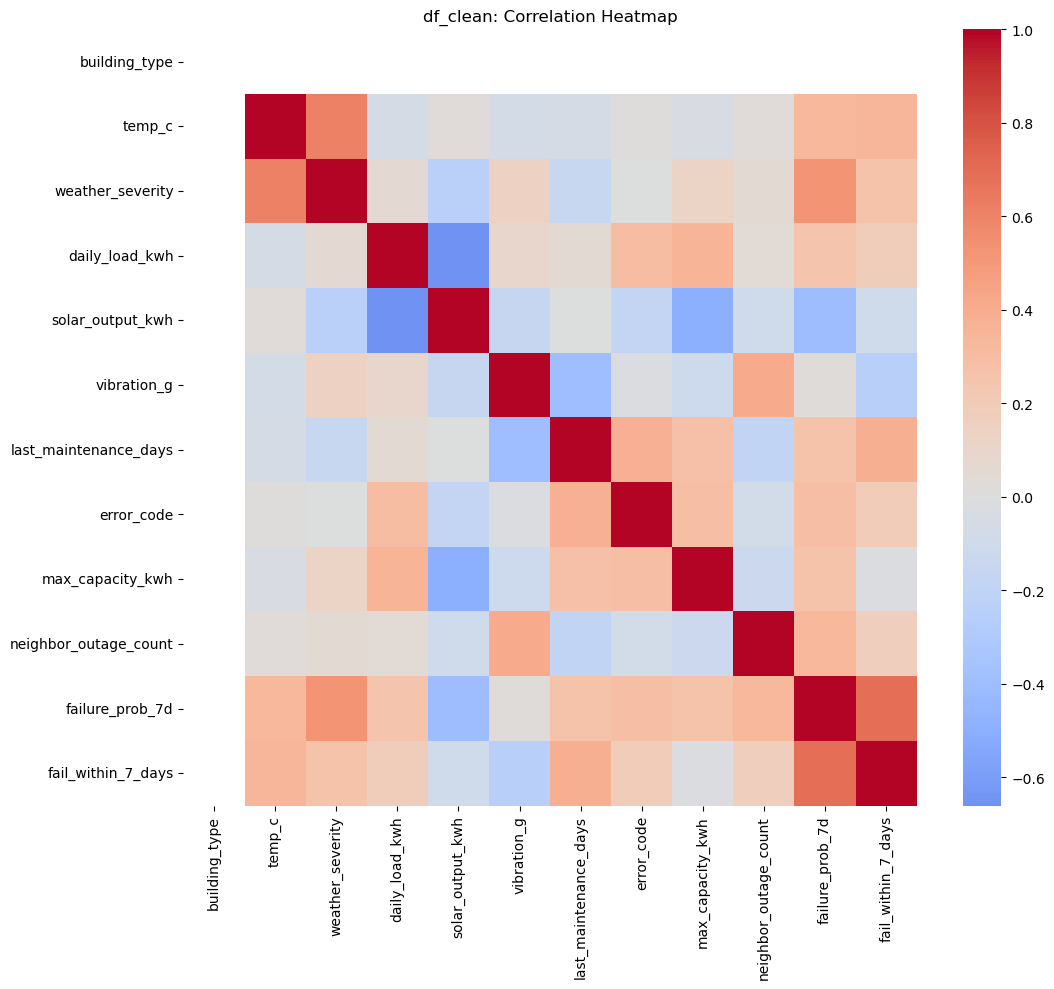

[SKIP] Not enough numeric columns in edges_clean for correlation


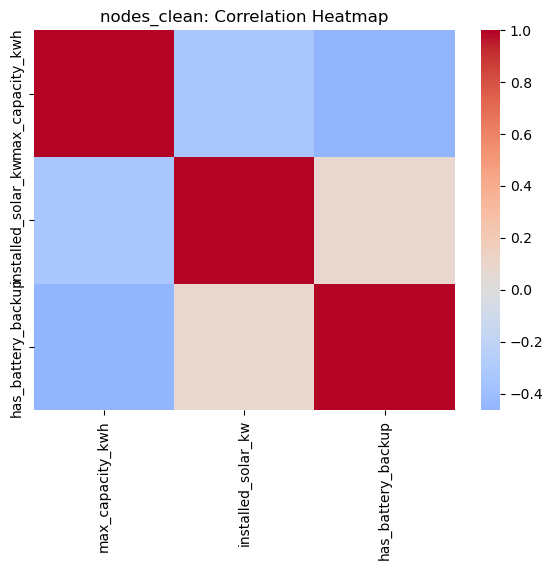

In [28]:
def corr_heatmap(df, name):
    if df is None: return
    num_cols = df.select_dtypes(include=np.number).columns
    if len(num_cols) < 2:
        print(f"[SKIP] Not enough numeric columns in {name} for correlation")
        return
    corr = df[num_cols].corr()
    plt.figure(figsize=(min(12, 0.6*len(num_cols)+4), min(10, 0.6*len(num_cols)+4)))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(f"{name}: Correlation Heatmap")
    plt.tight_layout()
    plt.show()

corr_heatmap(df_clean, "df_clean")
corr_heatmap(edges_clean,  "edges_clean")
corr_heatmap(nodes_clean,  "nodes_clean")

In [29]:
import networkx as nx
import pandas as pd

# Example: nodes.csv has ['node_id', 'building_type', ...]
#          edges.csv has ['from', 'to', ...]

# Build graph
G = nx.Graph()

# Add nodes with all attributes
for _, row in nodes.iterrows():
    G.add_node(row['node_id'], **row.to_dict())

for _, row in edges.iterrows():
    G.add_edge(row['from'], row['to'], **row.to_dict())

for node in G.nodes:
    if 'building_type' not in G.nodes[node] or pd.isna(G.nodes[node]['building_type']):
        G.nodes[node]['building_type'] = 'N/A'


In [30]:
centrality = nx.degree_centrality(G) # shows how many nodes are connected
betweenness = nx.betweenness_centrality(G) # shows how often node lies in shortedt path
closeness = nx.closeness_centrality(G) # shows how close a node is to other nodes

# Convert into dataframe
graph_features = pd.DataFrame({
    'node_id': list(centrality.keys()),
    'degree_centrality': list(centrality.values()),
    'betweenness_centrality': list(betweenness.values()),
    'closeness_centrality': list(closeness.values())
})


In [31]:
# Merge graph features into df
cleaned_df = df_clean.merge(graph_features, on='node_id', how='left')

cleaned_df.head()


,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,error_code,battery_backup,max_capacity_kwh,outage_today,neighbor_outage_count,failure_prob_7d,fail_within_7_days,degree_centrality,betweenness_centrality,closeness_centrality
0,2024-10-06,NODE_18,NaN,27.1,0,466.0,0.0,False,0.0170,219,0,True,2000,False,0,0.000000,0,0.157895,0.204678,0.387755
1,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1,0.105263,0.008772,0.339286
2,2024-08-20,NODE_10,NaN,29.9,0,1990.0,0.0,False,0.0079,405,3,False,6000,False,0,0.258319,1,0.263158,0.102339,0.487179
3,2024-08-20,NODE_10,NaN,29.9,0,1990.0,0.0,False,0.0079,405,3,False,6000,False,0,0.258319,1,0.263158,0.102339,0.487179
4,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1,0.105263,0.008772,0.339286


In [32]:
cleaned_df.tail()

,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,error_code,battery_backup,max_capacity_kwh,outage_today,neighbor_outage_count,failure_prob_7d,fail_within_7_days,degree_centrality,betweenness_centrality,closeness_centrality
9448,2024-10-26,NODE_09,NaN,36.4,2,1053.0,0.0,False,0.0180,8,0,False,4000,True,0,0.268414,1,0.315789,0.301170,0.542857
9449,2024-08-26,NODE_17,NaN,19.2,0,625.0,473.0,True,0.0197,216,0,False,5000,False,0,0.029609,0,0.157895,0.026316,0.413043
9450,2024-10-17,NODE_09,NaN,24.2,0,1573.0,0.0,False,0.0148,193,0,False,4000,True,0,0.027005,1,0.315789,0.301170,0.542857
9451,2024-09-02,NODE_16,NaN,31.3,2,1179.0,0.0,False,0.0205,429,1,False,6000,False,0,0.272509,1,0.105263,0.008772,0.339286
9452,2025-02-04,NODE_12,NaN,22.6,0,570.0,610.0,False,0.0308,45,0,False,2000,False,0,0.029896,0,0.263158,0.138402,0.475000


In [33]:

# Ensure numeric types ----
cleaned_df['daily_load_kwh'] = pd.to_numeric(cleaned_df['daily_load_kwh'], errors='coerce')
cleaned_df['solar_output_kwh'] = pd.to_numeric(cleaned_df['solar_output_kwh'], errors='coerce')
cleaned_df['max_capacity_kwh'] = pd.to_numeric(cleaned_df['max_capacity_kwh'], errors='coerce')

#  Sort for rolling calculations ----
cleaned_df = cleaned_df.sort_values(['node_id', 'date'])

# Rolling averages (7-day window, per node) ----
cleaned_df['rolling_load'] = (
    cleaned_df.groupby('node_id')['daily_load_kwh']
    .rolling(7, min_periods=1).mean()
    .reset_index(0, drop=True)
)

cleaned_df['rolling_solar'] = (
    cleaned_df.groupby('node_id')['solar_output_kwh']
    .rolling(7, min_periods=1).mean()
    .reset_index(0, drop=True)
)

#  Stress indicator ----
cleaned_df['stress_indicator'] = (
    cleaned_df['daily_load_kwh'] / cleaned_df['max_capacity_kwh']
)

In [34]:
 # 7. Average neighbor outages grouped by date ----
neighbor_avg = cleaned_df.groupby('date')['neighbor_outage_count'].mean().reset_index()
neighbor_avg.rename(columns={'neighbor_outage_count': 'avg_neighbor_outages'}, inplace=True)

if 'avg_neighbor_outages' in cleaned_df.columns:
    cleaned_df = cleaned_df.drop(columns=['avg_neighbor_outages'])

# Merge fresh values
cleaned_df = cleaned_df.merge(neighbor_avg, on='date', how='left')

In [35]:
# Keep only final useful columns
df_final = cleaned_df.copy()

print("Final dataset shape:", cleaned_df.shape)
cleaned_df.head()

Final dataset shape: (9453, 24)


,date,node_id,building_type,temp_c,weather_severity,daily_load_kwh,solar_output_kwh,spike_event,vibration_g,last_maintenance_days,...,neighbor_outage_count,failure_prob_7d,fail_within_7_days,degree_centrality,betweenness_centrality,closeness_centrality,rolling_load,rolling_solar,stress_indicator,avg_neighbor_outages
0,2024-08-02,NODE_01,NaN,25.9,1,888.0,0.0,False,0.0159,90,...,0,0.000000,0,0.263158,0.387914,0.542857,888.000000,0.0,0.148000,0.217391
1,2024-08-03,NODE_01,NaN,22.1,0,601.0,0.0,False,0.0290,91,...,0,0.054620,0,0.263158,0.387914,0.542857,744.500000,0.0,0.100167,0.000000
2,2024-08-03,NODE_01,NaN,22.1,0,601.0,0.0,False,0.0290,91,...,0,0.054620,0,0.263158,0.387914,0.542857,696.666667,0.0,0.100167,0.000000
3,2024-08-03,NODE_01,NaN,22.1,0,601.0,0.0,False,0.0290,91,...,0,0.054620,0,0.263158,0.387914,0.542857,672.750000,0.0,0.100167,0.000000
4,2024-08-04,NODE_01,NaN,28.5,0,491.0,0.0,False,0.0340,92,...,0,0.004234,0,0.263158,0.387914,0.542857,636.400000,0.0,0.081833,0.000000


[SKIP] df_clean has no valid numeric rows after dropna()


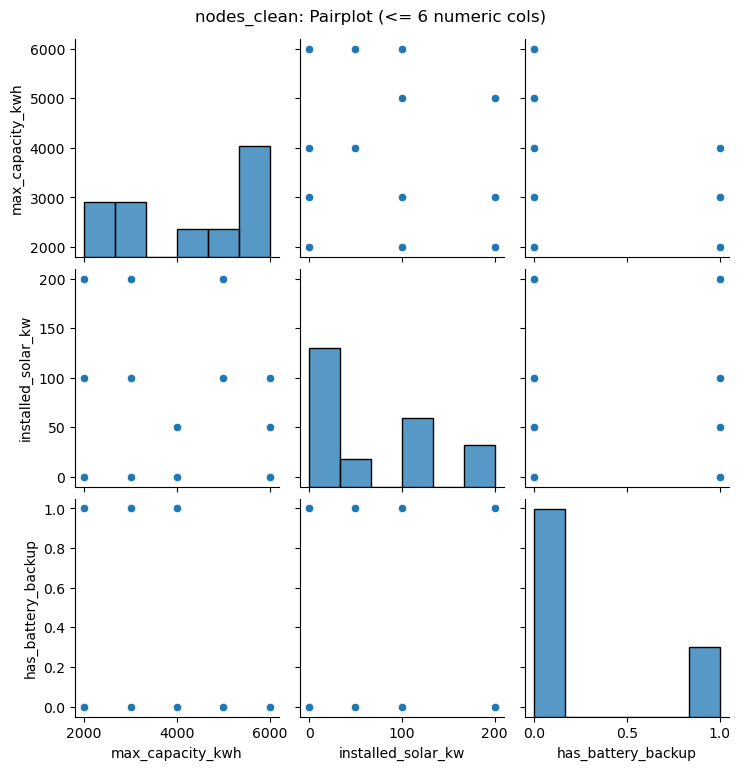

In [36]:
def safe_pairplot(df, name, max_cols=6):
    if df is None: 
        print(f"[SKIP] {name} is None")
        return

    # pick numeric columns
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_cols = num_cols[:max_cols]

    if len(num_cols) < 2:
        print(f"[SKIP] Not enough numeric columns in {name}")
        return

    # drop NA
    clean_df = df[num_cols].dropna()
    if clean_df.empty:
        print(f"[SKIP] {name} has no valid numeric rows after dropna()")
        return

    # sample if needed
    if len(clean_df) > 2000:
        clean_df = clean_df.sample(2000, random_state=42)

    sns.pairplot(clean_df)
    plt.suptitle(f"{name}: Pairplot (<= {max_cols} numeric cols)", y=1.02)
    plt.show()

# run
safe_pairplot(df_clean, "df_clean")
safe_pairplot(nodes_clean, "nodes_clean")


In [37]:

def prepare_model_data(
    df_final,
    target_col='fail_within_7_days',
    test_ratio=0.2     # proportion of data to reserve for testing
):
    """
    Prepare data for modeling with an automatic time-based split
    using the dataset's own date range and a given test_ratio.
    Works directly on the final cleaned dataset (df_final).
    """
    # Drop rows with missing target
    df_clean = df_final.dropna(subset=[target_col]).copy()
    df_clean['date'] = pd.to_datetime(df_clean['date'])

    # Exclude columns we don’t want to use as features
    exclude_cols = ['node_id', 'date', target_col]
    feature_cols = [c for c in df_clean.columns if c not in exclude_cols]

    # Label-encode categorical features if they exist
    categorical_cols = ['building_type', 'line_type', 'days_since_maintenance_bin']
    categorical_cols = [c for c in categorical_cols if c in feature_cols]
    label_encoders = {}
    for c in categorical_cols:
        le = LabelEncoder()
        df_clean[c] = le.fit_transform(df_clean[c].astype(str))
        label_encoders[c] = le

    # Fill missing values in features
    df_clean[feature_cols] = df_clean[feature_cols].fillna(0)

    # --- Automatic time split ---
    min_date, max_date = df_clean['date'].min(), df_clean['date'].max()
    split_point = min_date + (max_date - min_date) * (1 - test_ratio)
    print(f"Automatic split date: {split_point.date()} "
          f"(from {min_date.date()} to {max_date.date()})")

    train_mask = df_clean['date'] < split_point
    test_mask  = df_clean['date'] >= split_point

    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, target_col]
    X_test  = df_clean.loc[test_mask, feature_cols]
    y_test  = df_clean.loc[test_mask, target_col]

    print(f"Training set: {len(X_train)} samples, failure rate: {y_train.mean():.4f}")
    print(f"Test set   : {len(X_test)} samples, failure rate: {y_test.mean():.4f}")
    print(f"Number of features: {len(feature_cols)}")

    return X_train, X_test, y_train, y_test, feature_cols, label_encoders


In [38]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation"""
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = (model.predict_proba(X_test)[:, 1]
                    if hasattr(model, "predict_proba") else None)

    # Metrics
    f1 = f1_score(y_test, y_pred)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = np.trapz(recall, precision)  # Area under PR curve
    else:
        roc_auc = pr_auc = None

    # Print results
    print(f"\n=== {model_name} Results ===")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC : {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {
        "f1_score": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
    }


In [39]:
print("Date range in df_final:")
print(df_final['date'].min(), "→", df_final['date'].max())

# 2. Prepare train/test data
X_train, X_test, y_train, y_test, feature_cols, label_encoders = \
    prepare_model_data(df_final, test_ratio=0.2)   # 80% train / 20% test

# 3. Inspect outputs
print("\n=== Prepared Data Info ===")
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test  distribution:\n", y_test.value_counts(normalize=True))


Date range in df_final:
2024-08-01 00:00:00 → 2025-02-28 00:00:00
Automatic split date: 2025-01-16 (from 2024-08-01 to 2025-02-28)
Training set: 7996 samples, failure rate: 0.4886
Test set   : 1457 samples, failure rate: 0.2814
Number of features: 21

=== Prepared Data Info ===
X_train shape: (7996, 21)
X_test  shape: (1457, 21)
y_train distribution:
 fail_within_7_days
0    0.511381
1    0.488619
Name: proportion, dtype: float64
y_test  distribution:
 fail_within_7_days
0    0.7186
1    0.2814
Name: proportion, dtype: float64


Training Random Forest without leakage...

Best F1=0.6191 at threshold=0.010

Classification report (best threshold):
              precision    recall  f1-score   support

           0     0.8345    0.9293    0.8793      1047
           1     0.7457    0.5293    0.6191       410

    accuracy                         0.8167      1457
   macro avg     0.7901    0.7293    0.7492      1457
weighted avg     0.8095    0.8167    0.8061      1457

F1 Score:           0.6191155492154066
ROC-AUC:            0.689004589186293
Average Precision:  0.5256423413079211

Top 15 Most Important Features:
last_maintenance_days     0.176313
vibration_g               0.144345
temp_c                    0.125806
stress_indicator          0.090934
rolling_load              0.082630
daily_load_kwh            0.071237
closeness_centrality      0.059643
betweenness_centrality    0.051974
degree_centrality         0.045131
battery_backup            0.029133
weather_severity          0.028960
rolling_solar        

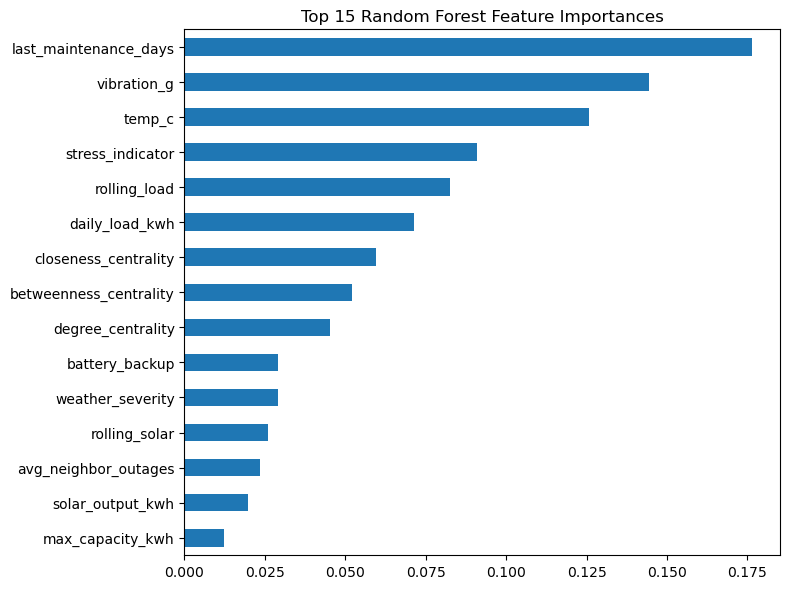

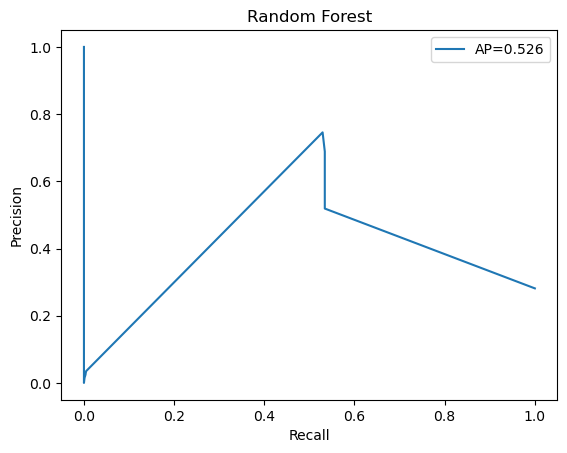

In [40]:

leakage_features = ["failure_prob_7d", "outage_today"]

X_train_model = X_train.drop(columns=[f for f in leakage_features if f in X_train.columns])
X_test_model  = X_test.drop(columns=[f for f in leakage_features if f in X_test.columns])

# 1. Train Random Forest
print("Training Random Forest without leakage...")

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_model, y_train)

# 2. Predict probabilities

y_prob = rf_model.predict_proba(X_test_model)[:, 1]

# 3. Find best F1 threshold
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thr[best_idx]
print(f"\nBest F1={f1_scores[best_idx]:.4f} at threshold={best_threshold:.3f}")

# Predictions at best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

# 4. Evaluate

print("\nClassification report (best threshold):")
print(classification_report(y_test, y_pred_best, digits=4))

print("F1 Score:          ", f1_score(y_test, y_pred_best))
print("ROC-AUC:           ", roc_auc_score(y_test, y_prob))
print("Average Precision: ", average_precision_score(y_test, y_prob))

# 5. Feature importance

feature_importance = pd.Series(rf_model.feature_importances_, index=X_train_model.columns).sort_values(ascending=False)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

#  bar plot
feature_importance.head(15).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 15 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

plt.plot(rec, prec, label=f"AP={average_precision_score(y_test, y_prob):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest")
plt.legend()
plt.show()


In [41]:
# 6. Risk analysis
risk_df = X_test_model.copy()
risk_df['actual_failure'] = y_test
risk_df['predicted_failure'] = y_pred_best
risk_df['failure_probability'] = y_prob

# Risk categories
risk_df['risk_category'] = pd.cut(
    risk_df['failure_probability'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Low', 'Medium', 'High', 'Critical']
)

false_negatives = risk_df[(risk_df['actual_failure'] == 1) & (risk_df['predicted_failure'] == 0)]
false_positives = risk_df[(risk_df['actual_failure'] == 0) & (risk_df['predicted_failure'] == 1)]

print(f"\nFalse negatives: {len(false_negatives)}")
print(f"False positives: {len(false_positives)}")

print("\nRisk Category Distribution:")
print(risk_df['risk_category'].value_counts())

print("\nActual Failure Rate by Risk Category:")
risk_by_category = risk_df.groupby('risk_category')['actual_failure'].agg(['count', 'sum', 'mean'])
risk_by_category.columns = ['total', 'failures', 'failure_rate']
print(risk_by_category)



False negatives: 193
False positives: 74

Risk Category Distribution:
risk_category
Low         422
Medium        0
High          0
Critical      0
Name: count, dtype: int64

Actual Failure Rate by Risk Category:
               total  failures  failure_rate
risk_category                               
Low              422       219      0.518957
Medium             0         0           NaN
High               0         0           NaN
Critical           0         0           NaN


In [42]:
# Store results (after finding best threshold)
rf_results = {
    "f1_score": f1_scores[best_idx],   # corrected
    "roc_auc": roc_auc_score(y_test, y_prob),
    "pr_auc": average_precision_score(y_test, y_prob),
    "best_threshold": thr[best_idx]
}


Training XGBoost...

Best F1=0.7984 at threshold=0.000

Classification report (threshold=0.000):
              precision    recall  f1-score   support

           0     1.0000    0.8023    0.8903      1047
           1     0.6645    1.0000    0.7984       410

    accuracy                         0.8579      1457
   macro avg     0.8323    0.9011    0.8444      1457
weighted avg     0.9056    0.8579    0.8645      1457

F1 Score:           0.7984420642648491
ROC-AUC:            0.9027628299205628
Average Precision:  0.8140306575847138

Top 15 Most Important Features:
battery_backup            0.160856
temp_c                    0.147104
degree_centrality         0.121264
vibration_g               0.111400
last_maintenance_days     0.088775
stress_indicator          0.080340
daily_load_kwh            0.059806
rolling_load              0.044716
error_code                0.040371
max_capacity_kwh          0.038662
weather_severity          0.033561
closeness_centrality      0.028650
avg_ne

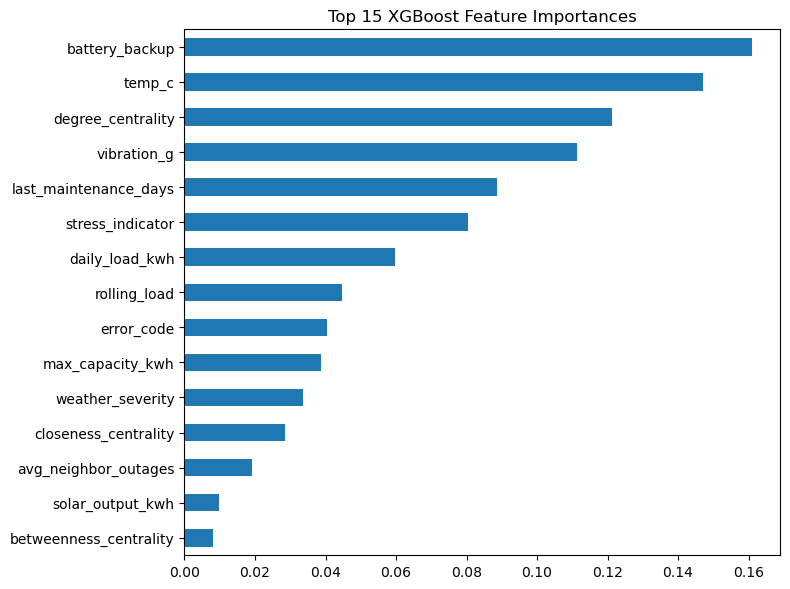

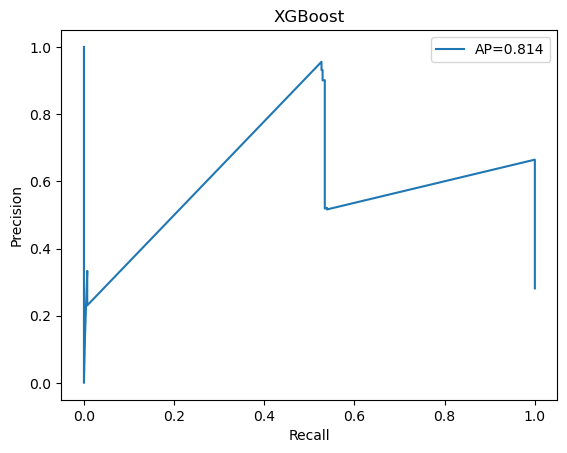

In [43]:
# Define leakage features
leakage_features = ["failure_prob_7d", "outage_today"]

# Remove leakage features from train/test sets
X_train_model = X_train.drop(columns=[f for f in leakage_features if f in X_train.columns])
X_test_model  = X_test.drop(columns=[f for f in leakage_features if f in X_test.columns])

print("Training XGBoost...")

# Compute scale_pos_weight for imbalance
scale_pos = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    random_state=42,
    eval_metric="aucpr",
    use_label_encoder=False
)

xgb_model.fit(
    X_train_model,
    y_train,
    eval_set=[(X_test_model, y_test)],
    verbose=False
)

y_prob = xgb_model.predict_proba(X_test_model)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thr[best_idx]
print(f"\nBest F1={f1_scores[best_idx]:.4f} at threshold={best_thresh:.3f}")

y_pred = (y_prob >= best_thresh).astype(int)

print(f"\nClassification report (threshold={best_thresh:.3f}):")
print(classification_report(y_test, y_pred, digits=4))
print("F1 Score:          ", f1_score(y_test, y_pred))
print("ROC-AUC:           ", roc_auc_score(y_test, y_prob))
print("Average Precision: ", average_precision_score(y_test, y_prob))

feature_importance = (
    pd.Series(xgb_model.feature_importances_, index=X_train_model.columns)
      .sort_values(ascending=False)
)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

feature_importance.head(15).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 15 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

plt.plot(rec, prec, label=f"AP={average_precision_score(y_test, y_prob):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost")
plt.legend()
plt.show()




In [44]:
# 6. Risk analysis for XGBoost
risk_df = X_test_model.copy()
risk_df['actual_failure'] = y_test
risk_df['predicted_failure'] = (y_prob >= best_thresh).astype(int)
risk_df['failure_probability'] = y_prob

# Risk categories
risk_df['risk_category'] = pd.cut(
    risk_df['failure_probability'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Low', 'Medium', 'High', 'Critical']
)

# False negatives / false positives
false_negatives = risk_df[
    (risk_df['actual_failure'] == 1) & (risk_df['predicted_failure'] == 0)
]
false_positives = risk_df[
    (risk_df['actual_failure'] == 0) & (risk_df['predicted_failure'] == 1)
]

print(f"\nFalse negatives (missed failures): {len(false_negatives)}")
print(f"False positives (false alarms):   {len(false_positives)}")

print("\nRisk Category Distribution:")
print(risk_df['risk_category'].value_counts())

print("\nActual Failure Rate by Risk Category:")
risk_by_category = risk_df.groupby('risk_category')['actual_failure'].agg(['count', 'sum', 'mean'])
risk_by_category.columns = ['total', 'failures', 'failure_rate']
print(risk_by_category)



False negatives (missed failures): 0
False positives (false alarms):   207

Risk Category Distribution:
risk_category
Low         1457
Medium         0
High           0
Critical       0
Name: count, dtype: int64

Actual Failure Rate by Risk Category:
               total  failures  failure_rate
risk_category                               
Low             1457       410        0.2814
Medium             0         0           NaN
High               0         0           NaN
Critical           0         0           NaN


In [45]:
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thr[best_idx - 1]  # Correct threshold

# Predictions using best threshold
y_pred_best = (y_prob >= best_thresh).astype(int)

# Store results
xgb_results = {
    "f1_score": f1_score(y_test, y_pred_best),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "pr_auc": average_precision_score(y_test, y_prob),
    "best_threshold": best_thresh
}

Training LightGBM...
[LightGBM] [Info] Number of positive: 3907, number of negative: 4089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2054
[LightGBM] [Info] Number of data points in the train set: 7996, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's average_precision: 0.582559	valid_0's binary_logloss: 0.599061

Best F1=0.6518 at threshold=0.316

Classification report (threshold=0.316):
              precision    recall  f1-score   support

           0     0.8402    0.9589    0.8956 

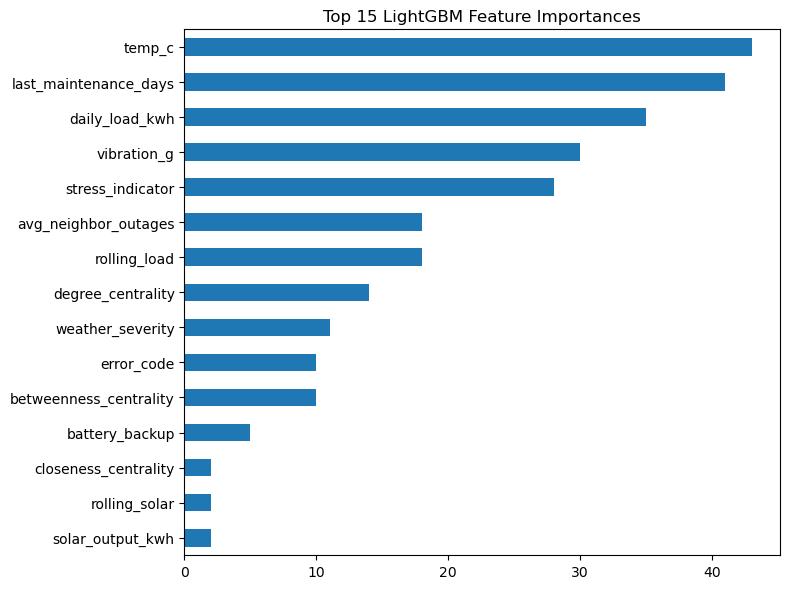

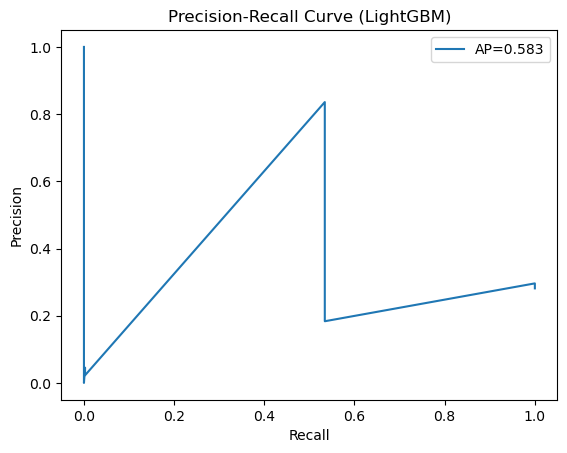

In [46]:
# --- 0. Remove leakage features ---
leakage_features = ["failure_prob_7d", "outage_today"]
X_train_model = X_train.drop(columns=[f for f in leakage_features if f in X_train.columns])
X_test_model  = X_test.drop(columns=[f for f in leakage_features if f in X_test.columns])

print("Training LightGBM...")

# --- 1. Handle imbalance ---
lgb_model = LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",   # handles imbalance
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(
    X_train_model,
    y_train,
    eval_set=[(X_test_model, y_test)],
    eval_metric="average_precision",
    callbacks=[
        lgb.early_stopping(50),    # stop if no improvement
        lgb.log_evaluation(-1)     # suppress logs
    ]
)

# --- 2. Predictions ---
y_prob = lgb_model.predict_proba(X_test_model)[:, 1]

# --- 3. Threshold tuning (best F1) ---
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thresh = thr[best_idx]

print(f"\nBest F1={f1_scores[best_idx]:.4f} at threshold={best_thresh:.3f}")

y_pred = (y_prob >= best_thresh).astype(int)

# --- 4. Evaluation ---
print(f"\nClassification report (threshold={best_thresh:.3f}):")
print(classification_report(y_test, y_pred, digits=4))
print("F1 Score:          ", f1_score(y_test, y_pred))
print("ROC-AUC:           ", roc_auc_score(y_test, y_prob))
print("Average Precision: ", average_precision_score(y_test, y_prob))

# --- 5. Feature Importance ---
feature_importance = (
    pd.Series(lgb_model.feature_importances_, index=X_train_model.columns)
      .sort_values(ascending=False)
)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

feature_importance.head(15).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 15 LightGBM Feature Importances")
plt.tight_layout()
plt.show()

# --- 6. Precision-Recall Curve ---
plt.plot(rec, prec, label=f"AP={average_precision_score(y_test, y_prob):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightGBM)")
plt.legend()
plt.show()


In [47]:
# --- Risk Analysis ---
risk_df = X_test.copy()  # use original test set (do not drop features)
risk_df['actual_failure'] = y_test
risk_df['predicted_failure'] = y_pred_best
risk_df['failure_probability'] = y_prob

# Risk categories
risk_df['risk_category'] = pd.cut(
    risk_df['failure_probability'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Low', 'Medium', 'High', 'Critical']
)

# Identify false negatives and false positives
false_negatives = risk_df[
    (risk_df['actual_failure'] == 1) & (risk_df['predicted_failure'] == 0)
]
false_positives = risk_df[
    (risk_df['actual_failure'] == 0) & (risk_df['predicted_failure'] == 1)
]

print(f"\nFalse negatives: {len(false_negatives)}")
print(f"False positives: {len(false_positives)}")

print("\nRisk Category Distribution:")
print(risk_df['risk_category'].value_counts())

print("\nActual Failure Rate by Risk Category:")
risk_by_category = risk_df.groupby('risk_category')['actual_failure'].agg(['count', 'sum', 'mean'])
risk_by_category.columns = ['total', 'failures', 'failure_rate']
print(risk_by_category)



False negatives: 0
False positives: 208

Risk Category Distribution:
risk_category
Medium      1456
High           1
Low            0
Critical       0
Name: count, dtype: int64

Actual Failure Rate by Risk Category:
               total  failures  failure_rate
risk_category                               
Low                0         0           NaN
Medium          1456       410      0.281593
High               1         0      0.000000
Critical           0         0           NaN


In [48]:
# Find best threshold for F1
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1_vals = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = f1_vals.argmax()
best_thresh = thr[best_idx] if best_idx < len(thr) else 0.5  # safe check

# Compute metrics at best threshold
y_pred_best = (y_prob >= best_thresh).astype(int)
best_f1_score = f1_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

# Store results safely
lgb_results = {
    "f1_score": best_f1_score,
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "best_threshold": best_thresh
}

In [49]:
print("\n=== MODEL COMPARISON ===")
models_comparison = pd.DataFrame({
    'Model':    ['Random Forest', 'XGBoost', 'LightGBM'],
    'F1 Score': [rf_results['f1_score'],
                 xgb_results['f1_score'],
                 lgb_results['f1_score']],
    'ROC AUC':  [rf_results['roc_auc'],
                 xgb_results['roc_auc'],
                 lgb_results['roc_auc']],
    'PR AUC':   [rf_results['pr_auc'],
                 xgb_results['pr_auc'],
                 lgb_results['pr_auc']]
})
print(models_comparison)



=== MODEL COMPARISON ===
           Model  F1 Score   ROC AUC    PR AUC
0  Random Forest  0.619116  0.689005  0.525642
1        XGBoost  0.797665  0.902763  0.814031
2       LightGBM  0.651786  0.544741  0.582559


In [50]:
# Choose best model
best_model_idx = models_comparison['F1 Score'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\nBest model: {best_model_name}")

if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    best_model = lgb_model



Best model: XGBoost


In [51]:
feature_importance_df = pd.DataFrame({
    'feature': feature_cols[:len(best_model.feature_importances_)],  # truncate to match
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))

                   feature  importance
9           battery_backup    0.160856
1                   temp_c    0.147104
12   neighbor_outage_count    0.121264
6              vibration_g    0.111400
7    last_maintenance_days    0.088775
17            rolling_load    0.080340
3           daily_load_kwh    0.059806
15  betweenness_centrality    0.044716
8               error_code    0.040371
10        max_capacity_kwh    0.038662


In [52]:
def analyze_risk_7d(model, X_test, y_test, X_train, threshold=None, use_quantiles=False, leakage_features=None):
    """
    Analyze risk factors for failure within 7 days, handling leakage and dynamic risk binning.

    Parameters:
    - model: trained scikit-learn / XGBoost / LightGBM model
    - X_test: test features (can contain leakage columns)
    - y_test: true labels (1 = failure within 7 days)
    - X_train: training features used for fitting model (leakage-free)
    - threshold: probability threshold for classification (if None, use best F1)
    - use_quantiles: if True, use quantiles for risk categories
    - leakage_features: list of features to drop from test set
    """

    if leakage_features is None:
        leakage_features = ["failure_prob_7d", "outage_today"]

    # Drop leakage features from test set
    X_test_clean = X_test.drop(columns=[f for f in leakage_features if f in X_test.columns])
    X_test_clean = X_test_clean[X_train.columns]  # align columns

    # Get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_clean)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test_clean)
        y_prob = (scores - scores.min()) / (scores.max() - scores.min())
    else:
        y_prob = model.predict(X_test_clean)

    # Determine threshold
    if threshold is None:
        prec, rec, thr = precision_recall_curve(y_test, y_prob)
        f1_vals = 2 * (prec * rec) / (prec + rec + 1e-9)
        best_idx = f1_vals.argmax()
        threshold = thr[best_idx]
        print(f"\nBest F1={f1_vals[best_idx]:.4f} at threshold={threshold:.3f}")

    y_pred = (y_prob >= threshold).astype(int)

    # Risk DataFrame
    risk_df = X_test_clean.copy()
    risk_df['actual_failure_7d'] = y_test
    risk_df['predicted_failure_7d'] = y_pred
    risk_df['failure_probability_7d'] = y_prob

    # Risk categories (dynamic)
    if use_quantiles:
        # quantile-based bins
        risk_df['risk_category'] = pd.qcut(
            risk_df['failure_probability_7d'],
            q=[0, 0.25, 0.5, 0.75, 1.0],
            labels=['Low', 'Medium', 'High', 'Critical']
        )
    else:
        # fixed bins, but ensure at least one sample in each
        min_prob, max_prob = y_prob.min(), y_prob.max()
        bins = np.linspace(min_prob, max_prob, 5)
        risk_df['risk_category'] = pd.cut(
            risk_df['failure_probability_7d'],
            bins=bins,
            labels=['Low', 'Medium', 'High', 'Critical'],
            include_lowest=True
        )

    # False negatives / false positives
    false_negatives = risk_df[
        (risk_df['actual_failure_7d'] == 1) & (risk_df['predicted_failure_7d'] == 0)
    ]
    false_positives = risk_df[
        (risk_df['actual_failure_7d'] == 0) & (risk_df['predicted_failure_7d'] == 1)
    ]

    # Metrics output
    print("=== RISK ANALYSIS: FAILURE WITHIN 7 DAYS ===")
    print(f"Threshold used: {threshold}")
    print(f"Total test samples: {len(risk_df)}")
    print(f"Actual failures: {risk_df['actual_failure_7d'].sum()}")
    print(f"Predicted failures: {risk_df['predicted_failure_7d'].sum()}")
    print(f"False negatives: {len(false_negatives)}")
    print(f"False positives: {len(false_positives)}\n")

    print("Risk Category Distribution:")
    print(risk_df['risk_category'].value_counts(), "\n")

    print("Actual Failure Rate by Risk Category:")
    risk_by_category = risk_df.groupby('risk_category')['actual_failure_7d'].agg(['count', 'sum', 'mean'])
    risk_by_category.columns = ['total', 'failures', 'failure_rate']
    print(risk_by_category)

    # ROC & PR metrics
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    print(f"\nROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}, F1 (at threshold): {f1_score(y_test, y_pred):.3f}")

    return risk_df, false_negatives, false_positives


In [53]:
# Suppose best_model is your chosen/trained XGBoost, LightGBM, or RF model
risk_df, false_negatives, false_positives = analyze_risk_7d(
    model=best_model,       
    X_test=X_test,           
    y_test=y_test,
    X_train=X_train_model,   
    threshold=None,         
    use_quantiles=False      
)



Best F1=0.7984 at threshold=0.000
=== RISK ANALYSIS: FAILURE WITHIN 7 DAYS ===
Threshold used: 0.00020338121976237744
Total test samples: 1457
Actual failures: 410
Predicted failures: 617
False negatives: 0
False positives: 207

Risk Category Distribution:
risk_category
Low         1447
Medium         6
Critical       4
High           0
Name: count, dtype: int64 

Actual Failure Rate by Risk Category:
               total  failures  failure_rate
risk_category                               
Low             1447       407      0.281272
Medium             6         3      0.500000
High               0         0           NaN
Critical           4         0      0.000000

ROC-AUC: 0.903, PR-AUC: 0.814, F1 (at threshold): 0.798


In [54]:
# Quick summary
print("False negatives:")
print(false_negatives.head())

print("\nFalse positives:")
print(false_positives.head())


False negatives:
Empty DataFrame
Columns: [building_type, temp_c, weather_severity, daily_load_kwh, solar_output_kwh, spike_event, vibration_g, last_maintenance_days, error_code, battery_backup, max_capacity_kwh, neighbor_outage_count, degree_centrality, betweenness_centrality, closeness_centrality, rolling_load, rolling_solar, stress_indicator, avg_neighbor_outages, actual_failure_7d, predicted_failure_7d, failure_probability_7d, risk_category]
Index: []

[0 rows x 23 columns]

False positives:
     building_type  temp_c  weather_severity  daily_load_kwh  \
199              0    23.5                 0           860.0   
200              0    32.1                 0           647.0   
206              0    22.8                 0          1045.0   
207              0    22.8                 0          1045.0   
217              0    33.7                 0          1069.0   

     solar_output_kwh  spike_event  vibration_g  last_maintenance_days  \
199               0.0        False      

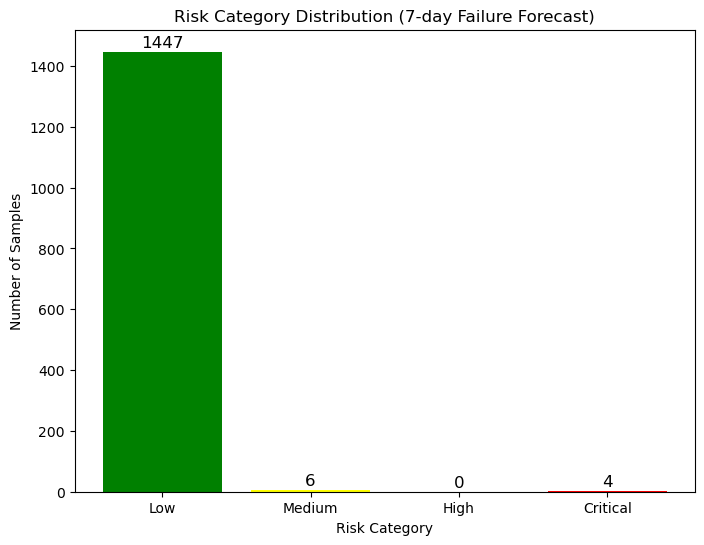

In [55]:
# Count of each risk category
risk_counts = risk_df['risk_category'].value_counts().sort_index()

# Bar plot
plt.figure(figsize=(8,6))
bars = plt.bar(risk_counts.index, risk_counts.values, color=['green', 'yellow', 'orange', 'red'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, str(height), ha='center', va='bottom', fontsize=12)

plt.title("Risk Category Distribution (7-day Failure Forecast)")
plt.ylabel("Number of Samples")
plt.xlabel("Risk Category")
plt.show()


In [56]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

def time_series_cv_evaluation(X, y, dates, model_class, model_params, n_splits=5):
    """Time series CV with safe handling of folds having only one class."""
    cv_results = []
    unique_dates = dates.sort_values().unique()
    fold_size = len(unique_dates) // (n_splits + 1)

    for i in range(n_splits):
        train_end = (i + 1) * fold_size
        test_end = (i + 2) * fold_size

        train_mask = (dates <= unique_dates[train_end - 1])
        test_mask = (dates > unique_dates[train_end - 1]) & (dates <= unique_dates[test_end - 1])

        X_train_cv, X_test_cv = X[train_mask], X[test_mask]
        y_train_cv, y_test_cv = y[train_mask], y[test_mask]

        if len(y_test_cv) == 0:
            continue  # no samples to test

        model = model_class(**model_params)
        model.fit(X_train_cv, y_train_cv)

        y_pred_cv = model.predict(X_test_cv)
        y_pred_proba_cv = model.predict_proba(X_test_cv)[:, 1]

        # Safe metrics
        if len(np.unique(y_test_cv)) < 2:
            f1_cv = 0.0
            roc_auc_cv = 0.5
            pr_auc_cv = y_test_cv.mean()  # baseline precision = prevalence
        else:
            f1_cv = f1_score(y_test_cv, y_pred_cv)
            roc_auc_cv = roc_auc_score(y_test_cv, y_pred_proba_cv)
            pr_auc_cv = average_precision_score(y_test_cv, y_pred_proba_cv)

        cv_results.append({
            'fold': i + 1,
            'train_period': f"{dates[train_mask].min()} to {dates[train_mask].max()}",
            'test_period': f"{dates[test_mask].min()} to {dates[test_mask].max()}",
            'train_samples': len(y_train_cv),
            'test_samples': len(y_test_cv),
            'test_failure_rate': y_test_cv.mean(),
            'f1_score': f1_cv,
            'roc_auc': roc_auc_cv,
            'pr_auc': pr_auc_cv
        })

    return pd.DataFrame(cv_results)


In [57]:

dates_series = pd.to_datetime(df_final['date'])
X_full = df_final[feature_cols].fillna(0)
y_full = df_final['fail_within_7_days']

# Remove NaN targets
valid_mask = ~y_full.isna()
X_full = X_full[valid_mask]
y_full = y_full[valid_mask]
dates_series = dates_series[valid_mask]

print("Performing time series cross-validation...")

xgb_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': (len(y_full) - sum(y_full)) / sum(y_full),  # imbalance fix
    'random_state': 42,
    'n_jobs': -1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

cv_results_xgb = time_series_cv_evaluation(
    X_full, y_full, dates_series, XGBClassifier, xgb_params
)

print("\nXGBoost CV Results:")
print(cv_results_xgb)

# Mean metrics (skip folds with NaN)
valid_f1 = cv_results_xgb['f1_score'][cv_results_xgb['f1_score'].apply(lambda x: x != "N/A")].astype(float)
valid_roc = cv_results_xgb['roc_auc'][cv_results_xgb['roc_auc'].apply(lambda x: x != "N/A")].astype(float)

print(f"\nMean F1 Score: {valid_f1.mean():.4f} ± {valid_f1.std():.4f}")
print(f"Mean ROC AUC: {valid_roc.mean():.4f} ± {valid_roc.std():.4f}")


Performing time series cross-validation...

XGBoost CV Results:
   fold                                train_period  \
0     1  2024-08-01 00:00:00 to 2024-09-04 00:00:00   
1     2  2024-08-01 00:00:00 to 2024-10-09 00:00:00   
2     3  2024-08-01 00:00:00 to 2024-11-13 00:00:00   
3     4  2024-08-01 00:00:00 to 2024-12-18 00:00:00   
4     5  2024-08-01 00:00:00 to 2025-01-22 00:00:00   

                                  test_period  train_samples  test_samples  \
0  2024-09-05 00:00:00 to 2024-10-09 00:00:00           1628          2563   
1  2024-10-10 00:00:00 to 2024-11-13 00:00:00           4191          2265   
2  2024-11-14 00:00:00 to 2024-12-18 00:00:00           6456           851   
3  2024-12-19 00:00:00 to 2025-01-22 00:00:00           7307           838   
4  2025-01-23 00:00:00 to 2025-02-26 00:00:00           8145          1241   

   test_failure_rate  f1_score   roc_auc    pr_auc  
0           0.673430  0.507347  0.901894  0.956200  
1           0.617660  0.724122

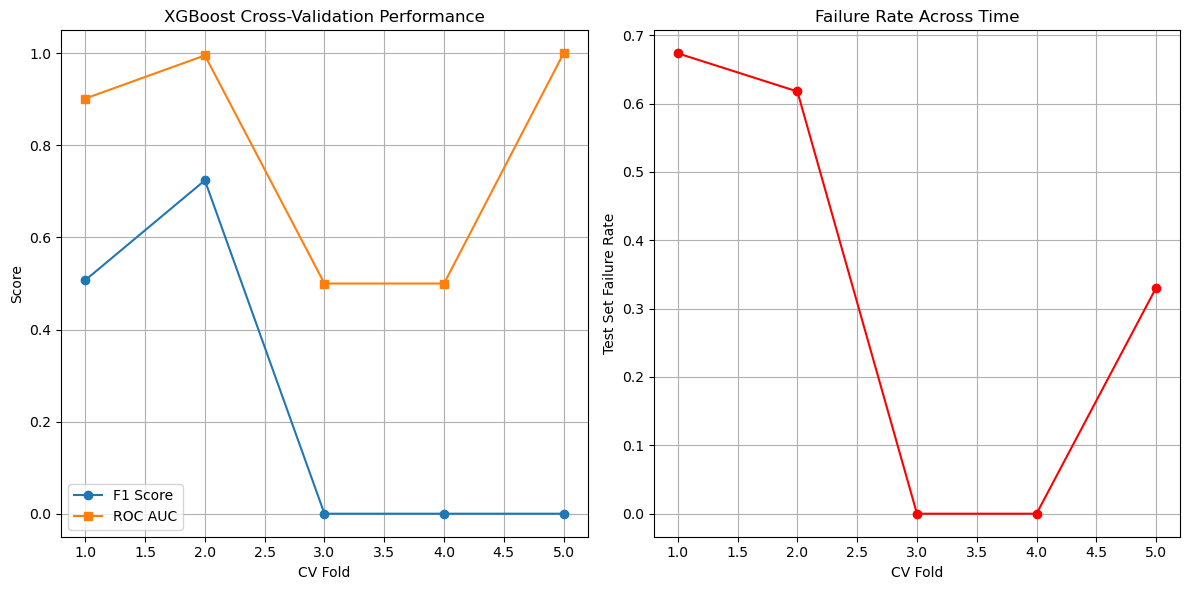

In [58]:
cv_results_xgb['f1_score'] = pd.to_numeric(cv_results_xgb['f1_score'], errors='coerce')
cv_results_xgb['roc_auc'] = pd.to_numeric(cv_results_xgb['roc_auc'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cv_results_xgb['fold'], cv_results_xgb['f1_score'], 'o-', label='F1 Score')
plt.plot(cv_results_xgb['fold'], cv_results_xgb['roc_auc'], 's-', label='ROC AUC')
plt.xlabel('CV Fold')
plt.ylabel('Score')
plt.title('XGBoost Cross-Validation Performance')
plt.legend()
plt.grid(True)

# Failure Rate Across Time
plt.subplot(1, 2, 2)
plt.plot(cv_results_xgb['fold'], cv_results_xgb['test_failure_rate'], 'o-', color='red')
plt.xlabel('CV Fold')
plt.ylabel('Test Set Failure Rate')
plt.title('Failure Rate Across Time')
plt.grid(True)

plt.tight_layout()
plt.show()


In [59]:
from datetime import timedelta

def simulate_real_time_deployment(model, df, feature_cols, simulation_days=30,
                                  high_risk_threshold=0.01, critical_risk_threshold=0.05):
    """Simulate real-time deployment for the last N days with flexible thresholds"""
    
    # Get the last N days of data
    latest_date = df['date'].max()
    start_date = latest_date - timedelta(days=simulation_days)
    
    simulation_data = df[df['date'] > start_date].copy()
    simulation_data = simulation_data.sort_values(['date', 'node_id'])
    
    daily_predictions = []
    alerts_generated = []
    
    for date in simulation_data['date'].unique():
        day_data = simulation_data[simulation_data['date'] == date]
        
        # Make predictions for this day
        X_day = day_data[feature_cols].fillna(0)
        
        if len(X_day) == 0:
            continue
        
        predictions = model.predict_proba(X_day)[:, 1]
        
        # Fill missing building_type if needed
        if 'building_type' not in day_data.columns:
            day_data['building_type'] = 'Unknown'
        else:
            day_data['building_type'] = day_data['building_type'].fillna('Unknown')
        
        day_results = day_data[['node_id', 'building_type']].copy()
        day_results['date'] = date
        day_results['failure_probability'] = predictions
        day_results['risk_level'] = pd.cut(predictions, 
                                          bins=[-1, high_risk_threshold, critical_risk_threshold, 1.0], 
                                          labels=['Low', 'High', 'Critical'])
        
        daily_predictions.append(day_results)
        
        # Generate alerts
        for _, node in day_results.iterrows():
            if node['failure_probability'] > high_risk_threshold:
                alert = {
                    'date': date,
                    'node_id': node['node_id'],
                    'building_type': node['building_type'],
                    'failure_probability': node['failure_probability'],
                    'alert_level': 'CRITICAL' if node['failure_probability'] > critical_risk_threshold else 'HIGH',
                    'recommended_action': 'Immediate inspection' if node['failure_probability'] > critical_risk_threshold else 'Schedule maintenance'
                }
                alerts_generated.append(alert)
    
    all_predictions = pd.concat(daily_predictions, ignore_index=True)
    alerts_df = pd.DataFrame(alerts_generated)
    
    return all_predictions, alerts_df


In [60]:
def generate_monitoring_dashboard_data(predictions_df, alerts_df):
    """Generate aggregated monitoring stats for dashboard display"""
    dashboard = {}

    # Daily risk stats
    daily_stats = (
        predictions_df
        .groupby('date')
        .agg(avg_risk=('failure_probability', 'mean'),
             max_risk=('failure_probability', 'max'),
             predictions=('node_id', 'count'))
        .reset_index()
    )
    dashboard['daily_stats'] = daily_stats

    # Risk distribution
    risk_distribution = (
        predictions_df
        .groupby(['date', 'risk_level'])
        .size()
        .unstack(fill_value=0)
    )
    dashboard['risk_distribution'] = risk_distribution

    # Building type risk
    building_risk = (
        predictions_df
        .groupby('building_type')['failure_probability']
        .agg(node_count='count', avg_risk='mean', max_risk='max')
        .sort_values('avg_risk', ascending=False)
    )
    dashboard['building_risk'] = building_risk

    # Alert statistics
    if alerts_df is not None and len(alerts_df) > 0:
        dashboard['daily_alerts'] = alerts_df.groupby('date')['alert_level'].count()
        dashboard['alert_by_type'] = alerts_df['alert_level'].value_counts()
        dashboard['alert_by_building'] = alerts_df['building_type'].value_counts()
    else:
        dashboard['daily_alerts'] = pd.Series(dtype=int)
        dashboard['alert_by_type'] = pd.Series(dtype=int)
        dashboard['alert_by_building'] = pd.Series(dtype=int)

    return dashboard


In [61]:

# Deployment Simulation & Dashboard
print("Simulating real-time deployment...")

# Use only features that match the trained model
model_features = X_train_model.columns.tolist()

# Simulate predictions and alerts
predictions_df, alerts_df = simulate_real_time_deployment(
    best_model, df_final, feature_cols=model_features, simulation_days=30
)

print(f"Simulation completed for {len(predictions_df['date'].unique())} days")
print(f"Total predictions made: {len(predictions_df)}")
print(f"Alerts generated: {len(alerts_df)}")

if len(alerts_df) > 0:
    print(f"Critical alerts: {len(alerts_df[alerts_df['alert_level'] == 'CRITICAL'])}")
    print(f"High alerts: {len(alerts_df[alerts_df['alert_level'] == 'HIGH'])}")

# Ensure correct building_type

# Map node_id to building_type from nodes.csv
node_building_map = nodes.set_index('node_id')['building_type'].to_dict()

# Assign building_type to predictions and alerts
predictions_df['building_type'] = predictions_df['node_id'].map(node_building_map).fillna('N/A')
if len(alerts_df) > 0:
    alerts_df['building_type'] = alerts_df['node_id'].map(node_building_map).fillna('N/A')


# Generate dashboard data

dashboard_data = generate_monitoring_dashboard_data(predictions_df, alerts_df)

# Aggregate building risk
dashboard_data['building_risk'] = (
    predictions_df
    .groupby('building_type')
    .agg(node_count=('node_id', 'count'),
         avg_risk=('failure_probability', 'mean'),
         max_risk=('failure_probability', 'max'))
    .sort_values('avg_risk', ascending=False)
)


# Display Dashboard

print("\n=== MONITORING DASHBOARD ===")
print("\nDaily Risk Statistics (last 10 days):")
print(dashboard_data['daily_stats'].tail(10))

print("\nBuilding Type Risk Analysis:")
if len(dashboard_data['building_risk']) > 0:
    print(dashboard_data['building_risk'])
else:
    print("- N/A")

if len(alerts_df) > 0:
    print("\nRecent Alerts (Last 5):")
    print(alerts_df.tail(5)[['date', 'node_id', 'building_type', 'failure_probability', 'alert_level']])


Simulating real-time deployment...
Simulation completed for 30 days
Total predictions made: 1145
Alerts generated: 4
Critical alerts: 0
High alerts: 4

=== MONITORING DASHBOARD ===

Daily Risk Statistics (last 10 days):
         date  avg_risk  max_risk  predictions
20 2025-02-19  0.001239  0.014786           24
21 2025-02-20  0.000070  0.000123           19
22 2025-02-21  0.000074  0.000323           19
23 2025-02-22  0.000141  0.000315           21
24 2025-02-23  0.000227  0.001100           23
25 2025-02-24  0.000121  0.000762           23
26 2025-02-25  0.000549  0.001796           25
27 2025-02-26  0.000423  0.005112           29
28 2025-02-27  0.000095  0.000430           32
29 2025-02-28  0.000088  0.001182           35

Building Type Risk Analysis:
               node_count  avg_risk  max_risk
building_type                                
Admin                 588  0.001346  0.004658
Sports_Center         186  0.000558  0.014786
Lab_Block              78  0.000246  0.001309
Lib

High-risk threshold: 0.003372
Critical-risk threshold: 0.003372


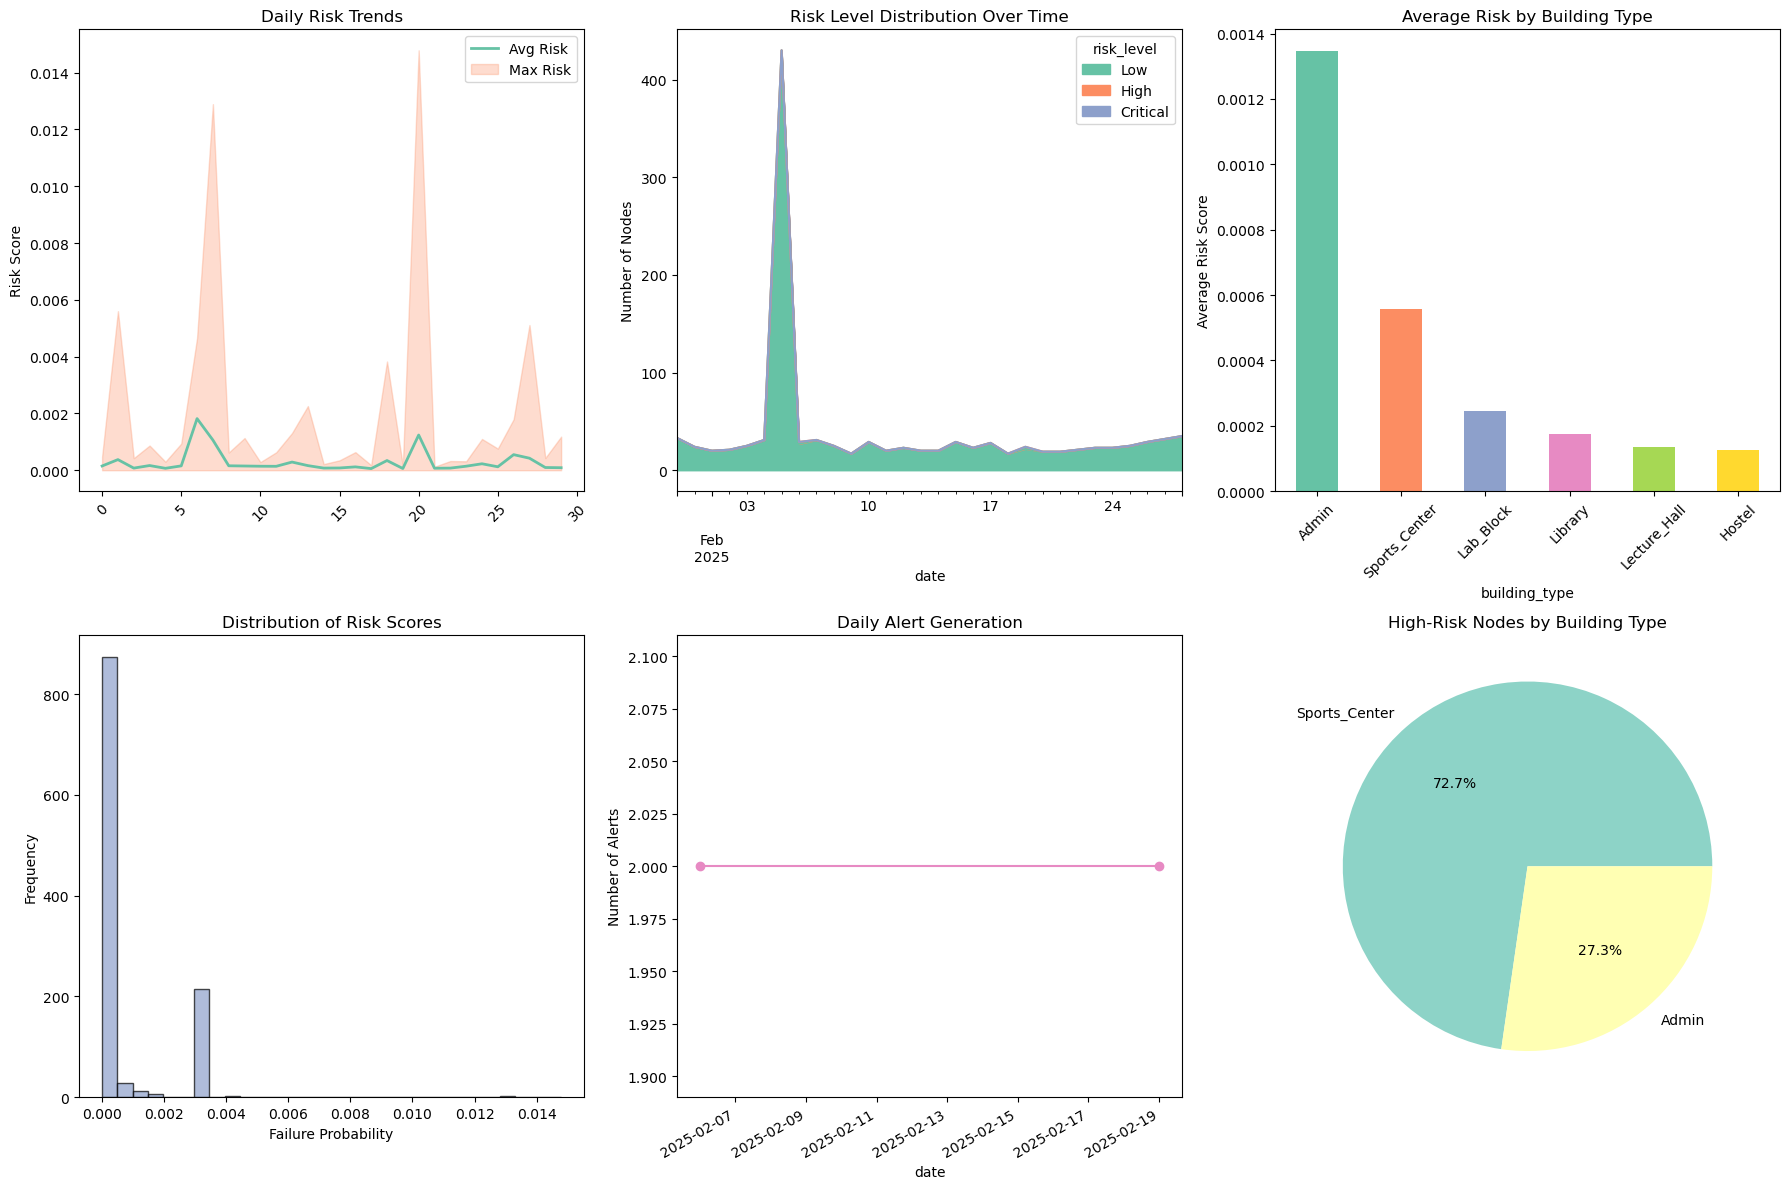


=== DEPLOYMENT INSIGHTS ===
Average daily risk score: 0.000288
Highest risk building type: Admin
Total high-risk predictions: 11
Alert rate: 0.35% of predictions


In [62]:

# Set a color palette
palette = sns.color_palette("Set2")  # nice distinct colors
pie_colors = sns.color_palette("Set3")  # for pie chart

# Deployment Simulation & Dashboard (with dynamic thresholds)

high_risk_threshold = predictions_df['failure_probability'].quantile(0.95)
critical_risk_threshold = predictions_df['failure_probability'].quantile(0.99)

print(f"High-risk threshold: {high_risk_threshold:.6f}")
print(f"Critical-risk threshold: {critical_risk_threshold:.6f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Daily risk trend
axes[0,0].plot(dashboard_data['daily_stats'].index, 
               dashboard_data['daily_stats']['avg_risk'], 
               color=palette[0], linewidth=2, label='Avg Risk')
axes[0,0].fill_between(dashboard_data['daily_stats'].index, 0, 
                       dashboard_data['daily_stats']['max_risk'], 
                       color=palette[1], alpha=0.3, label='Max Risk')
axes[0,0].set_title('Daily Risk Trends')
axes[0,0].set_ylabel('Risk Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()

# Risk distribution
if len(dashboard_data['risk_distribution']) > 0:
    dashboard_data['risk_distribution'].plot(kind='area', ax=axes[0,1], stacked=True, color=palette, legend=True)
    axes[0,1].set_title('Risk Level Distribution Over Time')
    axes[0,1].set_ylabel('Number of Nodes')
else:
    axes[0,1].text(0.5, 0.5, 'No Risk Data', ha='center', va='center')

# Building type risk
if len(dashboard_data['building_risk']) > 0:
    dashboard_data['building_risk']['avg_risk'].plot(kind='bar', ax=axes[0,2], color=palette)
    axes[0,2].set_title('Average Risk by Building Type')
    axes[0,2].set_ylabel('Average Risk Score')
    axes[0,2].tick_params(axis='x', rotation=45)
else:
    axes[0,2].text(0.5, 0.5, 'No Building Data', ha='center', va='center')

# Risk score distribution
axes[1,0].hist(predictions_df['failure_probability'], bins=30, color=palette[2], alpha=0.7, edgecolor='black')
axes[1,0].set_title('Distribution of Risk Scores')
axes[1,0].set_xlabel('Failure Probability')
axes[1,0].set_ylabel('Frequency')

# Alert generation over time
if len(dashboard_data['daily_alerts']) > 0:
    dashboard_data['daily_alerts'].plot(kind='line', ax=axes[1,1], color=palette[3], marker='o')
    axes[1,1].set_title('Daily Alert Generation')
    axes[1,1].set_ylabel('Number of Alerts')
else:
    axes[1,1].text(0.5, 0.5, 'No Alerts', ha='center', va='center')

# High-risk nodes by building type (using dynamic thresholds)
high_risk_nodes = predictions_df[predictions_df['failure_probability'] > high_risk_threshold]
if len(high_risk_nodes) > 0:
    high_risk_by_building = high_risk_nodes['building_type'].value_counts()
    high_risk_by_building.plot(kind='pie', ax=axes[1,2], autopct='%1.1f%%', colors=pie_colors)
    axes[1,2].set_ylabel('')
    axes[1,2].set_title('High-Risk Nodes by Building Type')
else:
    axes[1,2].text(0.5, 0.5, 'No High-Risk Nodes', ha='center', va='center')

plt.tight_layout()
plt.show()

# Deployment insights
print("\n=== DEPLOYMENT INSIGHTS ===")
print(f"Average daily risk score: {dashboard_data['daily_stats']['avg_risk'].mean():.6f}")
print(f"Highest risk building type: {dashboard_data['building_risk'].index[0] if len(dashboard_data['building_risk'])>0 else 'N/A'}")
print(f"Total high-risk predictions: {len(high_risk_nodes)}")

if len(alerts_df) > 0:
    print(f"Alert rate: {len(alerts_df) / len(predictions_df) * 100:.2f}% of predictions")

In [65]:
def generate_final_report(models_comparison, cv_results, dashboard_data, alerts_df,
                          feature_importance=None, predictions_df=None,
                          false_negatives=None, false_positives=None, y_test=None):
    """Generate comprehensive final report"""
    
    print("="*60)
    print("CASCADING POWER FAILURE PREDICTION - FINAL REPORT")
    print("="*60)
    
    print("\n1. MODEL PERFORMANCE SUMMARY")
    print("-" * 40)
    print(models_comparison)
    
    best_model_name = models_comparison.loc[models_comparison['F1 Score'].idxmax(), 'Model']
    best_f1 = models_comparison['F1 Score'].max()
    best_auc = models_comparison.loc[models_comparison['F1 Score'].idxmax(), 'ROC AUC']
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"F1 Score: {best_f1:.4f}")
    print(f"ROC AUC: {best_auc:.4f}")
    
    print(f"\n2. CROSS-VALIDATION ROBUSTNESS")
    print("-" * 40)
    print(f"Mean CV F1 Score: {cv_results['f1_score'].mean():.4f} ± {cv_results['f1_score'].std():.4f}")
    print(f"Mean CV ROC AUC: {cv_results['roc_auc'].mean():.4f} ± {cv_results['roc_auc'].std():.4f}")
    print(f"Model stability: {'GOOD' if cv_results['f1_score'].std() < 0.05 else 'MODERATE' if cv_results['f1_score'].std() < 0.1 else 'POOR'}")
    
    print(f"\n3. FEATURE IMPORTANCE INSIGHTS")
    print("-" * 40)
    print("Top contributing factors to failure prediction:")
    if feature_importance is not None:
        if 'feature' in feature_importance.columns:
            top_features = feature_importance.head(10)['feature'].tolist()
        elif 'Feature' in feature_importance.columns:
            top_features = feature_importance.head(10)['Feature'].tolist()
        else:
            top_features = feature_importance.head(10).iloc[:, 0].tolist()
        for i, feature in enumerate(top_features[:5], 1):
            print(f"{i}. {feature}")
    else:
        print("Feature importance data not available.")
    
    print(f"\n4. RISK ANALYSIS")
    print("-" * 40)
    print(f"Building types with highest risk:")
    if len(dashboard_data['building_risk']) > 0:
        for building_type, risk_data in dashboard_data['building_risk'].head(3).iterrows():
            print(f"- {building_type}: {risk_data['avg_risk']:.4f} average risk")
    else:
        print("No building risk data available.")
    
    print(f"\n5. DEPLOYMENT SIMULATION RESULTS")
    print("-" * 40)
    if len(alerts_df) > 0 and predictions_df is not None:
        print(f"Alert generation rate: {len(alerts_df)}/{len(predictions_df)} predictions ({len(alerts_df)/len(predictions_df)*100:.1f}%)")
        print(f"Critical alerts: {len(alerts_df[alerts_df['alert_level'] == 'CRITICAL'])}")
        print(f"High priority alerts: {len(alerts_df[alerts_df['alert_level'] == 'HIGH'])}")
    else:
        print("No alerts generated during simulation period")
    
    print(f"\n6. SAFETY AND RELIABILITY ASSESSMENT")
    print("-" * 40)
    if false_negatives is not None and false_positives is not None and y_test is not None:
        print(f"False negative rate: {len(false_negatives)}/{y_test.sum()} actual failures")
        print(f"False positive rate: {len(false_positives)}/{len(y_test) - y_test.sum()} non-failures")
        
        safety_score = 1 - (len(false_negatives) / max(1, y_test.sum()))
        reliability_score = 1 - (len(false_positives) / max(1, len(y_test) - y_test.sum()))
        
        print(f"Safety score (1 - false negative rate): {safety_score:.3f}")
        print(f"Reliability score (1 - false positive rate): {reliability_score:.3f}")
    else:
        safety_score = reliability_score = None
        print("Safety and reliability data not available.")
    
    print(f"\n7. RECOMMENDATIONS")
    print("-" * 40)
    if best_f1 > 0.7:
        print("✓ Model performance is GOOD - suitable for production deployment")
    elif best_f1 > 0.5:
        print("! Model performance is MODERATE - consider additional feature engineering")
    else:
        print("✗ Model performance is POOR - requires significant improvement")
    
    if cv_results['f1_score'].std() < 0.05:
        print("✓ Model is stable across time periods")
    else:
        print("! Model shows temporal instability - monitor for concept drift")
    
    if safety_score is not None:
        if safety_score > 0.8:
            print("✓ Low false negative rate - good safety profile")
        else:
            print("! High false negative rate - consider lowering prediction threshold")
    
    print("\n8. OPERATIONAL DEPLOYMENT GUIDELINES")
    print("-" * 40)
    print("- Deploy model with daily batch prediction schedule")
    print("- Set alert thresholds: Critical (>0.8), High (>0.5), Medium (>0.3)")
    print("- Implement human-in-the-loop validation for critical alerts")
    print("- Monitor model performance weekly and retrain monthly")
    print("- Maintain maintenance logs to validate predictions")
    print("- Consider ensemble approaches for critical infrastructure")
    
    return {
        'best_model': best_model_name,
        'performance': {'f1': best_f1, 'auc': best_auc},
        'stability': cv_results['f1_score'].std(),
        'safety_score': safety_score,
        'reliability_score': reliability_score
    }

# Generate final report
final_report = generate_final_report(
    models_comparison, cv_results_xgb, dashboard_data, alerts_df,
    feature_importance=feature_importance_df,
    predictions_df=predictions_df,
    false_negatives=false_negatives,
    false_positives=false_positives,
    y_test=y_test
)

print(f"\n9. TECHNICAL IMPLEMENTATION NOTES")
print("-" * 40)
print("Technologies used in this implementation:")
print("- Feature Engineering: Pandas, NumPy, NetworkX")
print("- Machine Learning: Scikit-learn, XGBoost, LightGBM")
print("- Explainability: SHAP")
print("- Visualization: Matplotlib, Seaborn")
print("- Time Series Validation: Custom implementation")

print(f"\nModel artifacts saved:")
print(f"- Best model: {final_report['best_model']}")
print(f"- Feature columns: {len(feature_cols)} features")
print(f"- Label encoders: {len(label_encoders)} categorical variables")

print("\n10. 7-DAY FAILURE FORECAST")
print("-" * 40)

if predictions_df is not None:
    # Set dynamic forecast threshold (top 5% of failure probabilities)
    forecast_threshold = predictions_df['failure_probability'].quantile(0.95)
    print(f"Forecast threshold set at top 5%: {forecast_threshold:.3f}")

    # Filter nodes above threshold
    high_risk_nodes = predictions_df[predictions_df['failure_probability'] >= forecast_threshold].copy()

    if len(high_risk_nodes) > 0:
        # Aggregate to show max probability per node
        unique_high_risk = high_risk_nodes.groupby(['node_id', 'building_type'])['failure_probability'].max().reset_index()
        for idx, row in unique_high_risk.iterrows():
            print(f"- {row['node_id']} ({row['building_type']}): {row['failure_probability']:.3f} probability")
        print(f"Total predicted failures in next 7 days: {len(unique_high_risk)}")
    else:
        print("No nodes predicted to fail in the next 7 days")
else:
    print("Prediction data not available")

    
print(f"\n{'='*60}")
print("ANALYSIS COMPLETE")
print(f"{'='*60}")


CASCADING POWER FAILURE PREDICTION - FINAL REPORT

1. MODEL PERFORMANCE SUMMARY
----------------------------------------
           Model  F1 Score   ROC AUC    PR AUC
0  Random Forest  0.619116  0.689005  0.525642
1        XGBoost  0.797665  0.902763  0.814031
2       LightGBM  0.651786  0.544741  0.582559

Best performing model: XGBoost
F1 Score: 0.7977
ROC AUC: 0.9028

2. CROSS-VALIDATION ROBUSTNESS
----------------------------------------
Mean CV F1 Score: 0.2463 ± 0.3459
Mean CV ROC AUC: 0.7795 ± 0.2581
Model stability: POOR

3. FEATURE IMPORTANCE INSIGHTS
----------------------------------------
Top contributing factors to failure prediction:
1. battery_backup
2. temp_c
3. neighbor_outage_count
4. vibration_g
5. last_maintenance_days

4. RISK ANALYSIS
----------------------------------------
Building types with highest risk:
- Admin: 0.0013 average risk
- Sports_Center: 0.0006 average risk
- Lab_Block: 0.0002 average risk

5. DEPLOYMENT SIMULATION RESULTS
------------------------

In [67]:
df_final.to_csv("Power_Timeseries1.csv", index=False)


In [68]:
import pandas as pd
df = pd.read_csv("Power_Timeseries1.csv")
print(df.head())

         date  node_id  building_type  temp_c  weather_severity  \
0  2024-08-02  NODE_01            NaN    25.9                 1   
1  2024-08-03  NODE_01            NaN    22.1                 0   
2  2024-08-03  NODE_01            NaN    22.1                 0   
3  2024-08-03  NODE_01            NaN    22.1                 0   
4  2024-08-04  NODE_01            NaN    28.5                 0   

   daily_load_kwh  solar_output_kwh  spike_event  vibration_g  \
0           888.0               0.0        False       0.0159   
1           601.0               0.0        False       0.0290   
2           601.0               0.0        False       0.0290   
3           601.0               0.0        False       0.0290   
4           491.0               0.0        False       0.0340   

   last_maintenance_days  ...  neighbor_outage_count  failure_prob_7d  \
0                     90  ...                      0         0.000000   
1                     91  ...                      0        

In [69]:
df_final['building_type'].isna().sum()

# See a few rows to confirm
df_final[['node_id','building_type']].head(10)

,node_id,building_type
0,NODE_01,NaN
1,NODE_01,NaN
2,NODE_01,NaN
3,NODE_01,NaN
4,NODE_01,NaN
5,NODE_01,NaN
6,NODE_01,NaN
7,NODE_01,NaN
8,NODE_01,NaN
9,NODE_01,NaN


In [71]:
df = pd.read_csv("Power_Timeseries1.csv")

# Load nodes.csv which contains node_id -> building_type mapping

# Create mapping
node_building_map = nodes.set_index('node_id')['building_type'].to_dict()

# Assign building_type to your main dataframe
df['building_type'] = df['node_id'].map(node_building_map).fillna('N/A')

print(df.head())

         date  node_id building_type  temp_c  weather_severity  \
0  2024-08-02  NODE_01       Library    25.9                 1   
1  2024-08-03  NODE_01       Library    22.1                 0   
2  2024-08-03  NODE_01       Library    22.1                 0   
3  2024-08-03  NODE_01       Library    22.1                 0   
4  2024-08-04  NODE_01       Library    28.5                 0   

   daily_load_kwh  solar_output_kwh  spike_event  vibration_g  \
0           888.0               0.0        False       0.0159   
1           601.0               0.0        False       0.0290   
2           601.0               0.0        False       0.0290   
3           601.0               0.0        False       0.0290   
4           491.0               0.0        False       0.0340   

   last_maintenance_days  ...  neighbor_outage_count  failure_prob_7d  \
0                     90  ...                      0         0.000000   
1                     91  ...                      0         0.054

In [73]:
df.to_csv("Power_Timeseries2.csv", index=False)